In [32]:
import os
import sys
import torch
import torch.nn as nn
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [33]:
TRAIN_DATASET_PATH = "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
MONAI_PATH= "MONAI-dev"

In [34]:
sys.path.append(MONAI_PATH)

In [35]:
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, Orientationd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld,
    RandAffined, SpatialPadd, EnsureTyped, CenterSpatialCropd
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, compute_dice, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference


In [36]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.get_device_name(0))  # Should print your GPU name


True
NVIDIA GeForce RTX 3070


# Preprocessing Data


In [37]:
from monai.transforms import Transform

class AddChannelTransform:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, data):
        for key in self.keys:
            data[key] = torch.unsqueeze(torch.tensor(data[key]), 0)  # Adds a channel dimension
        return data

In [38]:
from monai.transforms import Identity
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Assuming you have a CUDA device available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
keys = ["t1", "t2", "t1ce", "flair", "seg"]

# Instantiate your transformation with the KMeansTransform included
train_transforms = Compose([
    LoadImaged(keys=keys),
    AddChannelTransform(keys=keys),
    Orientationd(keys=keys, axcodes="RAS"),
    CropForegroundd(keys=keys, source_key="t1"),
    SpatialPadd(keys=keys, spatial_size=(160, 160, 80), mode="constant"),
    CenterSpatialCropd(keys=keys, roi_size=(160, 160, 80)),
    EnsureTyped(keys=keys),
    ])


# Prepare the dataset

In [43]:
data_dir = TRAIN_DATASET_PATH
patients = [patient for patient in os.listdir(data_dir) if patient.startswith("BraTS20_") and len(os.listdir(os.path.join(data_dir, patient))) == 5]

data_dicts = [{
    "filename": patient,
    "t1": os.path.join(data_dir, patient, patient+"_t1.nii"),
    "t2": os.path.join(data_dir, patient, patient+"_t2.nii"),
    "t1ce": os.path.join(data_dir, patient, patient+"_t1ce.nii"),
    "flair": os.path.join(data_dir, patient, patient+"_flair.nii"),
    "seg": os.path.join(data_dir, patient, patient+"_seg.nii"),
} for patient in patients if os.path.isdir(os.path.join(data_dir, patient))]

# Sorting the dictionaries by 'filename'
data_dicts = sorted(data_dicts, key=lambda x: x['filename'])


# Split the data_dicts for training and validation
train_files, val_files = data_dicts[:-60], data_dicts[-60:]

print(len(train_files))
print(len(val_files))

309
60


Preprocessing successful!


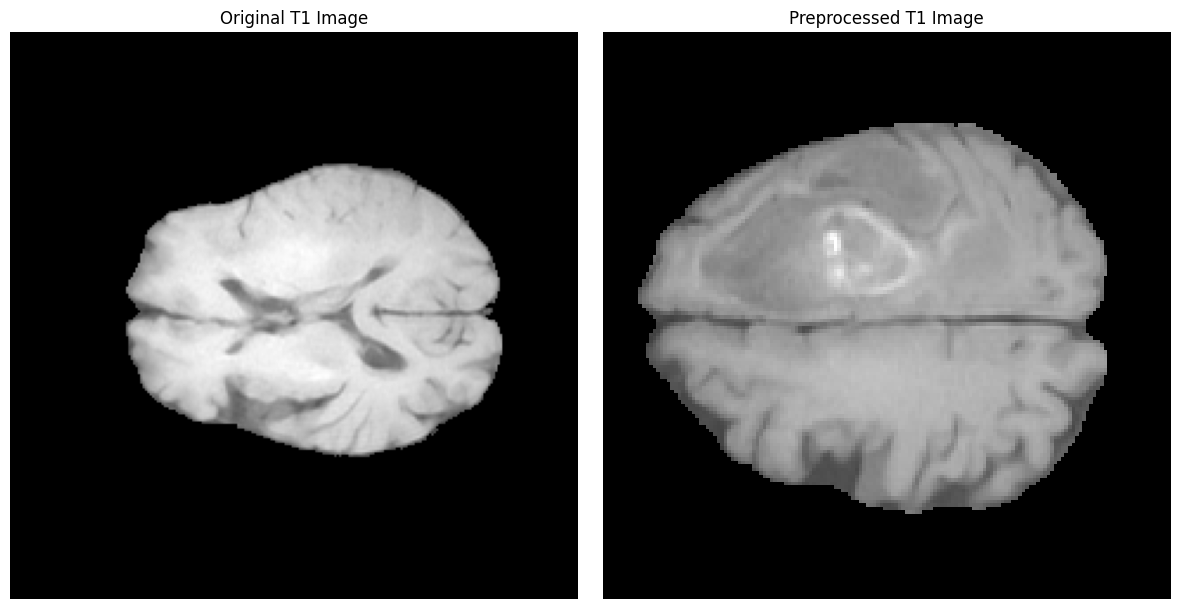

In [90]:
keys = ["t1", "t2", "t1ce", "flair", "seg"]


# Load a sample file before preprocessing
sample_file = {
    "t1": TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii',
    "t2": TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii',
    "t1ce": TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii',
    "flair": TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii',
    "seg": TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii',
}

# Apply preprocessing transformations
try:
    preprocessed_data = train_transforms(sample_file)
    print("Preprocessing successful!")
except Exception as e:
    print("Error during preprocessing:", e)
    raise

# Extract original and preprocessed T1 images
original_t1 = LoadImaged(keys=["t1"])(sample_file)["t1"]
preprocessed_t1 = preprocessed_data["t1"]

# Convert to NumPy arrays for visualization
if not isinstance(original_t1, np.ndarray):
    original_t1 = np.array(original_t1)
if not isinstance(preprocessed_t1, np.ndarray):
    preprocessed_t1 = np.array(preprocessed_t1)

# Select a middle slice for visualization
slice_index = original_t1.shape[-1] // 2  # Middle slice in z-dimension

# Plot the original and preprocessed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_t1[:, :, slice_index], cmap="gray")
plt.title("Original T1 Image")
plt.axis("off")

# Preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_t1[0, :, :, slice_index], cmap="gray")  # [0, :, :, :] to remove channel dim if present
plt.title("Preprocessed T1 Image")
plt.axis("off")

plt.tight_layout()
plt.show()


# Preprocess the dataset with the transformations

In [9]:
preprocessed_train_data = [train_transforms(item) for item in tqdm(train_files)]
preprocessed_val_data = [train_transforms(item) for item in tqdm(val_files)]

100%|██████████| 60/60 [01:34<00:00,  1.57s/it]


# Now create your MONAI dataset with the preprocessed data


In [10]:
train_ds_1 = Dataset(data=preprocessed_train_data, transform=Identity())
val_ds_1 = Dataset(data=preprocessed_val_data, transform=Identity())  # Assuming validation data doesn't need KMeansTransform


# Metrics and Loss

In [11]:
def binary_dice3d(s, g):
    num = np.sum(np.multiply(s, g))
    denom = s.sum() + g.sum()
    if denom == 0:
        return 1
    else:
        return 2.0 * num / denom

# Define the Dice coefficient for the whole tumor
def DSC_whole(pred, orig_label):
    return binary_dice3d(pred > 0, orig_label > 0)

# Define the Dice coefficient for the enhancing region
def DSC_en(pred, orig_label):
    # return binary_dice3d(pred == 4, orig_label == 4)
    return binary_dice3d(pred == 3, orig_label == 3)

# Define the Dice coefficient for the core region
def DSC_core(pred, orig_label):
    seg_ = np.copy(pred)
    ground_ = np.copy(orig_label)
    seg_[seg_ == 2] = 0
    ground_[ground_ == 2] = 0
    return binary_dice3d(seg_ > 0, ground_ > 0)

# Define the custom Dice metric class
class NewDiceMetric:
    def __init__(self):
        self.reset()

    def reset(self):
        self.whole_dice_scores = []
        self.enhancing_dice_scores = []
        self.core_dice_scores = []

    def update(self, outputs, targets):
        assert outputs.shape == targets.shape, "Outputs and targets must have the same shape"
        outputs = outputs.numpy() if isinstance(outputs, torch.Tensor) else outputs
        targets = targets.numpy() if isinstance(targets, torch.Tensor) else targets

        whole_dice = DSC_whole(outputs, targets)
        enhancing_dice = DSC_en(outputs, targets)
        core_dice = DSC_core(outputs, targets)

        self.whole_dice_scores.append(whole_dice)
        self.enhancing_dice_scores.append(enhancing_dice)
        self.core_dice_scores.append(core_dice)

    def aggregate(self):
        mean_whole_dice = np.mean(self.whole_dice_scores)
        mean_enhancing_dice = np.mean(self.enhancing_dice_scores)
        mean_core_dice = np.mean(self.core_dice_scores)

        return mean_whole_dice, mean_enhancing_dice, mean_core_dice


In [12]:
# Initialize the metric
metric = NewDiceMetric()

# Simulate some data
outputs = np.random.randint(0, 4, (1, 160, 160, 80))
targets = np.random.randint(0, 4, (1, 160, 160, 80))
print(outputs.shape, targets.shape)
print(np.unique(outputs), np.unique(targets))
# Update the metric with the batch
metric.update(outputs, targets)

# Aggregate the results to get the mean Dice scores
mean_whole_dice, mean_enhancing_dice, mean_core_dice = metric.aggregate()

print("Mean Whole Tumor Dice:", mean_whole_dice)
print("Mean Enhancing Region Dice:", mean_enhancing_dice)
print("Mean Core Region Dice:", mean_core_dice)

(1, 160, 160, 80) (1, 160, 160, 80)
[0 1 2 3] [0 1 2 3]
Mean Whole Tumor Dice: 0.7505526391651813
Mean Enhancing Region Dice: 0.25087082154579005
Mean Core Region Dice: 0.5000673484805597


# Define the custom Dice metric

In [13]:
class MyDiceMetric:
    def __init__(self, smooth=1e-6, include_background=True):
        self.smooth = smooth
        self.include_background = include_background
        self.reset()

    def reset(self):
        self.intersections = 0.0
        self.unions = 0.0

    def update(self, outputs, targets):
        assert outputs.shape == targets.shape, "Outputs and targets must have the same shape"

        if not self.include_background:
            outputs = outputs[:, 1:]  # Exclude background class
            targets = targets[:, 1:]  # Exclude background class

        outputs = outputs.contiguous()
        targets = targets.contiguous()

        intersection = (outputs * targets).sum(dim=(2, 3, 4))
        union = outputs.sum(dim=(2, 3, 4)) + targets.sum(dim=(2, 3, 4))

        self.intersections += intersection.sum(dim=1)
        self.unions += union.sum(dim=1)

    def aggregate(self):
        dice_score = (2.0 * self.intersections + self.smooth) / (self.unions + self.smooth)
        return dice_score.mean()


# Training and Validation

In [71]:
# to do elu selu celu gelu softmax logsoftmax sigmoid
activation = "sigmoid"
directory_path = os.path.join("D:/thesis/Final/batchDemo models", activation)
os.makedirs(directory_path, exist_ok=True)

print(f"Directory created: {directory_path}")

Directory created: D:/thesis/Final/batchDemo models\sigmoid


In [72]:
# Define the model
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(16, 32, 64, 128),  # Reduced number of layers
    strides=(1, 2, 2, 2),  # Reduced stride in the first layer
    kernel_size=3,  # Adjust kernel size if necessary
    act= activation  ####AMR ACTIVATION FUNCTION
    # upsample_mode='transpose',  # Consider changing upsample_mode
)

In [73]:
# Initialize the custom Dice loss
loss_function = DiceLoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [74]:
from monai.transforms import AsDiscrete, Compose

# Training loop
num_epochs = 50

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [76]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from monai.transforms import AsDiscrete
from monai.metrics import DiceMetric
from monai.transforms import EnsureType

In [77]:
# Initialize DiceMetric
dice_metric = MyDiceMetric(include_background=True)
metric = NewDiceMetric()

model.to(device)

start_epoch = 0  # Start from scratch

train_loader = DataLoader(train_ds_1, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds_1, batch_size=1, shuffle=False, num_workers=4)

# Optional: One-hot encoding transform for labels, if not done within the Dataset
one_hot_transform = AsDiscrete(to_onehot=4, dim=1)

In [78]:
import time
start_time = time.time()

In [79]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        inputs = torch.cat([
            batch_data["t1"], batch_data["t2"], batch_data["t1ce"], batch_data["flair"]
        ], dim=1).to(device)

        labels = batch_data["seg"].to(device)
        labels[labels == 4] = 3

        if labels.shape[1] != 1:
            labels = labels.unsqueeze(1)

        labels = one_hot_transform(labels)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Apply softmax if not included in the model
        outputs = torch.softmax(outputs, dim=1)

        # Ensure the outputs have the correct shape
        if outputs.shape != labels.shape:
            outputs = outputs.permute(0, 2, 1, 3, 4)

        # Make sure the shapes match before loss calculation
        assert outputs.shape == labels.shape, f"Shape mismatch: outputs {outputs.shape}, labels {labels.shape}"

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # model_save_path = "D:/thesis/batchDemo models/relu6/model_relu6_epoch_{}.pth".format(epoch+1)
    model_save_path = "D:/thesis/Final/batchDemo models/{}/model_{}_epoch_{}.pth".format(activation, activation, epoch + 1)

    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")


    # Validation phase
    # Start validation phase
    model.eval()
    dice_metric.reset()  # Reset the metric for new validation
    metric.reset()

    with torch.no_grad():
        for val_batch_data in val_loader:
            val_inputs = torch.cat([
                val_batch_data["t1"], val_batch_data["t2"], val_batch_data["t1ce"], val_batch_data["flair"]
            ], dim=1).to(device)

            val_labels = val_batch_data["seg"].to(device)
            val_labels[val_labels == 4] = 3  # Remap class 4 to class 3

            # Ensure val_labels have a single channel dimension before one-hot encoding
            if val_labels.shape[1] != 1:
                val_labels = val_labels.unsqueeze(1)

            # Apply one-hot encoding to labels if necessary
            val_labels = one_hot_transform(val_labels)

            val_outputs = model(val_inputs)
            val_outputs = torch.softmax(val_outputs, dim=1)

            # Ensure val_outputs and val_labels have the same shape
            if val_outputs.shape != val_labels.shape:
                val_outputs = val_outputs.permute(0, 2, 1, 3, 4)

            # Ensure val_outputs and val_labels are on the CPU for metric calculation
            val_outputs = val_outputs.cpu()
            val_labels = val_labels.cpu()
            new_val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)
            new_val_labels = torch.argmax(val_labels, dim=1, keepdim=True)

            new_val_outputs = torch.squeeze(new_val_outputs, dim=1)
            new_val_labels = torch.squeeze(new_val_labels, dim=1)

            dice_metric.update(outputs=val_outputs, targets=val_labels)
            metric.update(new_val_outputs,new_val_labels)

        # Aggregate and print the final mean Dice score for the validation set
        mean_dice = dice_metric.aggregate().item()
        print(f"Epoch {epoch+1} - Mean Dice score on validation set: {mean_dice}")
        dice_metric.reset()

        # Aggregate the results to get the mean Dice scores
        mean_whole_dice, mean_enhancing_dice, mean_core_dice = metric.aggregate()
        print(f"Epoch {epoch+1} - Mean Dice score on validation set: Whole Tumor {mean_whole_dice}, Enhancing {mean_enhancing_dice}, Core {mean_core_dice}")
        metric.reset()


    print(f"Average loss: {epoch_loss / len(train_loader)}")

end_time = time.time()
trainingTime = end_time - start_time
print("time in sec:")
print(trainingTime)


Epoch 1/50
Model saved at D:/thesis/Final/batchDemo models/sigmoid/model_sigmoid_epoch_1.pth
Epoch 1 - Mean Dice score on validation set: 0.9424591064453125
Epoch 1 - Mean Dice score on validation set: Whole Tumor 0.49538368492906215, Enhancing 0.3446942365349758, Core 0.2840142476365929
Average loss: 0.6605846243383043
Epoch 2/50
Model saved at D:/thesis/Final/batchDemo models/sigmoid/model_sigmoid_epoch_2.pth
Epoch 2 - Mean Dice score on validation set: 0.9525958299636841
Epoch 2 - Mean Dice score on validation set: Whole Tumor 0.666260174900225, Enhancing 0.41491541958594474, Core 0.3587999177834922
Average loss: 0.5120132270368557
Epoch 3/50
Model saved at D:/thesis/Final/batchDemo models/sigmoid/model_sigmoid_epoch_3.pth
Epoch 3 - Mean Dice score on validation set: 0.9605618119239807
Epoch 3 - Mean Dice score on validation set: Whole Tumor 0.6719551833043381, Enhancing 0.44840726929215574, Core 0.5032534618610152
Average loss: 0.4577606287588965
Epoch 4/50
Model saved at D:/thesis

# Validation phase


In [118]:
import re

# Read the log file
modelAcName= "TANH"
pathLogs= "D:/thesis/Final/batchDemo models"
file_path = "{}/model_{}_LOG.txt".format(pathLogs,modelAcName)
with open(file_path, "r") as file:
    lines = file.readlines()
    
# Initialize lists to store extracted data
epochs = []
mean_dice_scores = []
whole_tumor_scores = []
enhancing_scores = [] 
core_scores = []
average_losses = []

# Parse the log file
for line in lines:
    epoch_match = re.match(r"Epoch (\d+)/50", line)
    if epoch_match:
        epoch = int(epoch_match.group(1))
        epochs.append(epoch)
    elif "Mean Dice score on validation set:" in line and "Whole Tumor" not in line:
        mean_dice = float(line.split(": ")[-1].strip())
        mean_dice_scores.append(mean_dice)
    elif "Mean Dice score on validation set: Whole Tumor" in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        whole_tumor_scores.append(float(values[1]))
        enhancing_scores.append(float(values[2]))
        core_scores.append(float(values[3]))
    elif "Average loss:" in line:
        average_loss = float(line.split(": ")[-1].strip())
        average_losses.append(average_loss)

# Create the LaTeX table using the longtable format
latex_table = r"""
\begin{longtable}{|c|c|c|c|c|c|}
\hline
\textbf{Epoch} & \textbf{Mean Dice} & \textbf{Whole Tumor} & \textbf{Enhancing} & \textbf{Core} & \textbf{Loss} \\ 
\hline
\endfirsthead
\hline
\textbf{Epoch} & \textbf{Mean Dice} & \textbf{Whole Tumor} & \textbf{Enhancing} & \textbf{Core} & \textbf{Loss} \\ 
\hline
\endhead
\hline
\multicolumn{6}{|r|}{{Continued on next page}} \\ 
\hline
\endfoot
\hline
\endlastfoot
"""

# Add rows to the table
for i in range(len(epochs)):
    latex_table += f"{epochs[i]} & {mean_dice_scores[i]:.4f} & {whole_tumor_scores[i]:.4f} & {enhancing_scores[i]:.4f} & {core_scores[i]:.4f} & {average_losses[i]:.4f} \\\\\n"

# Close the table
latex_table += r"""
\hline
\caption{Summary of validation scores and losses across epochs for }
\label{tab:validation_scores}
\end{longtable}
"""

# Save the LaTeX table to a file
output_file = "longtable_latex {}.tex".format(modelAcName)
with open(output_file, "w") as file:
    file.write(latex_table)

print(f"LaTeX table saved to {output_file}")


LaTeX table saved to longtable_latex TANH.tex


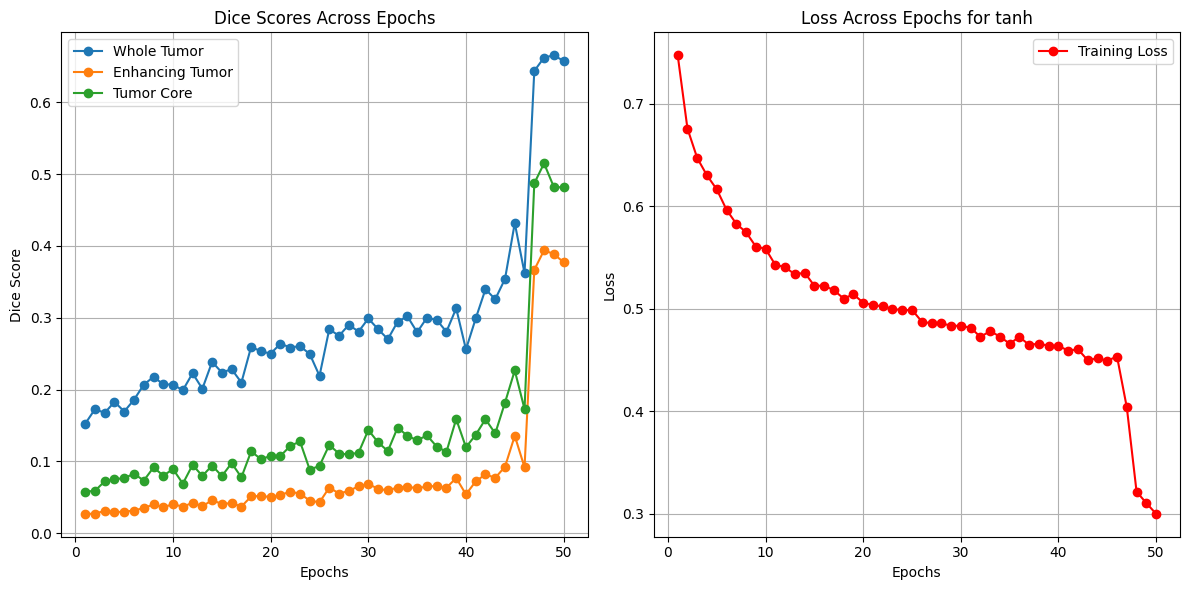

In [1]:
import re
import matplotlib.pyplot as plt

# Read the log file
modelAcName= "tanh"
pathLogs= "D:/thesis/Final/batchDemo models/"
file_path = "{}model_{}_LOG.txt".format(pathLogs,modelAcName)
with open(file_path, "r") as file:
    lines = file.readlines()
  
# Initialize lists to store extracted data
epochs = []
mean_dice_scores = []
whole_tumor_scores = []
enhancing_scores = []
core_scores = []
average_losses = []

# Parse the log file
for line in lines:
    epoch_match = re.match(r"Epoch (\d+)/50", line)
    if epoch_match:
        epoch = int(epoch_match.group(1))
        epochs.append(epoch)
    elif "Mean Dice score on validation set:" in line and "Whole Tumor" not in line:
        mean_dice = float(line.split(": ")[-1].strip())
        mean_dice_scores.append(mean_dice)
    elif "Mean Dice score on validation set: Whole Tumor" in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        whole_tumor_scores.append(float(values[1]))
        enhancing_scores.append(float(values[2]))
        core_scores.append(float(values[3]))
    elif "Average loss:" in line:
        average_loss = float(line.split(": ")[-1].strip())
        average_losses.append(average_loss)

# Create line charts
plt.figure(figsize=(12, 6))

# Plot Dice scores
plt.subplot(1, 2, 1)
plt.plot(epochs, whole_tumor_scores, label="Whole Tumor", marker='o')
plt.plot(epochs, enhancing_scores, label="Enhancing Tumor", marker='o')
plt.plot(epochs, core_scores, label="Tumor Core", marker='o')
plt.title("Dice Scores Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.legend()
plt.grid()

# Plot Loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, average_losses, label="Training Loss", color="red", marker='o')
plt.title("Loss Across Epochs for {}".format(modelAcName))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("performance_trends.png", dpi=300)
plt.show()


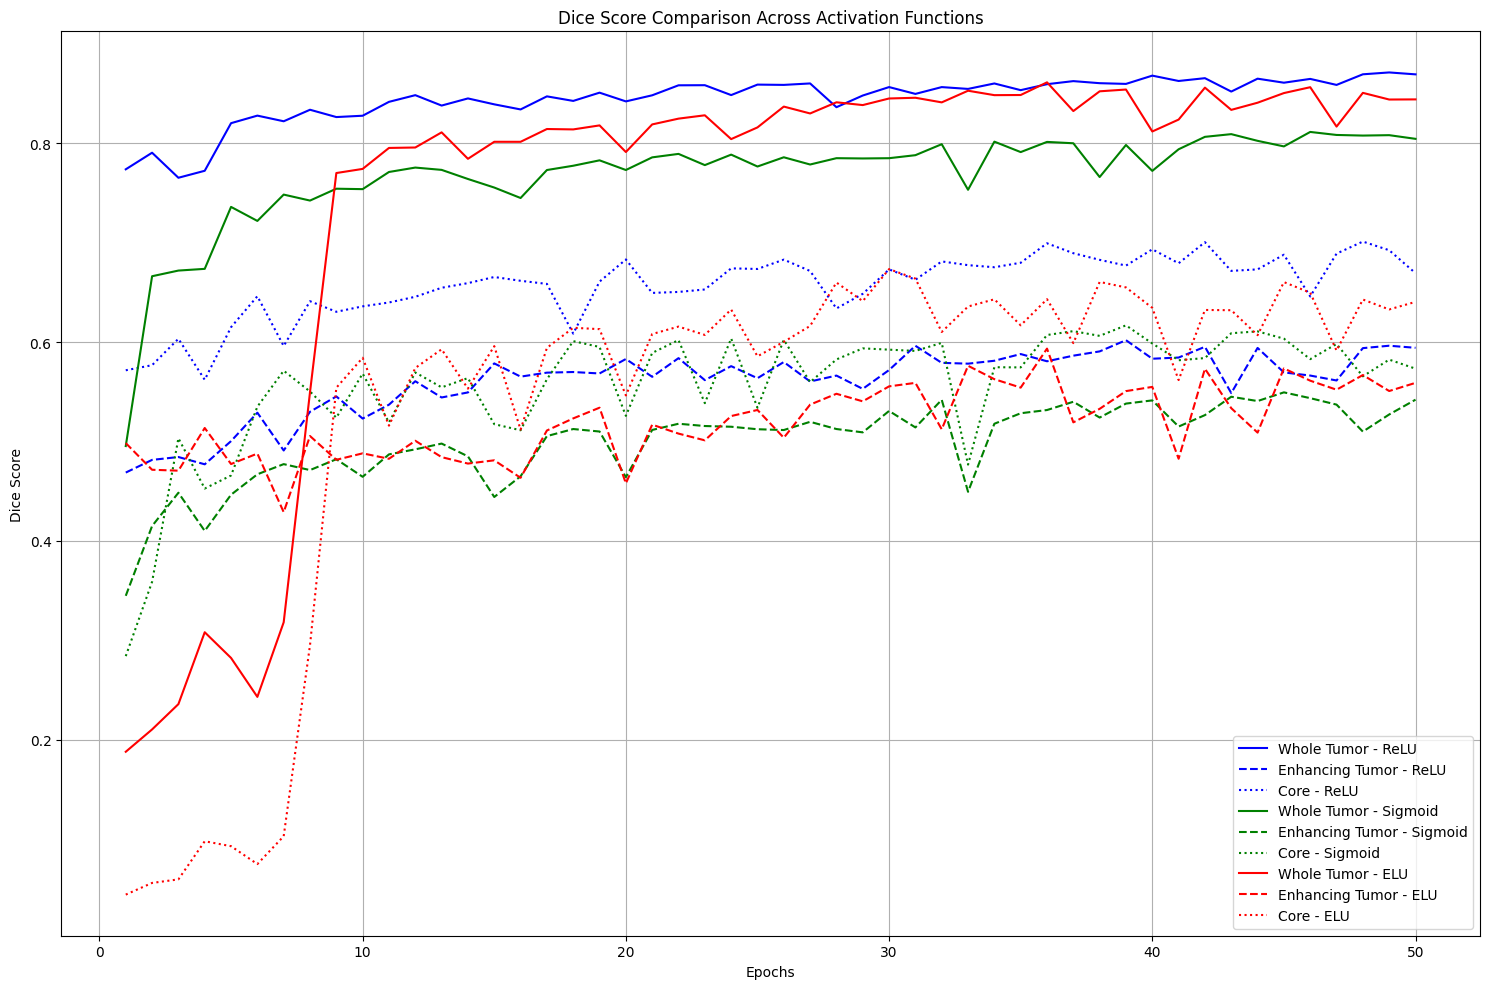

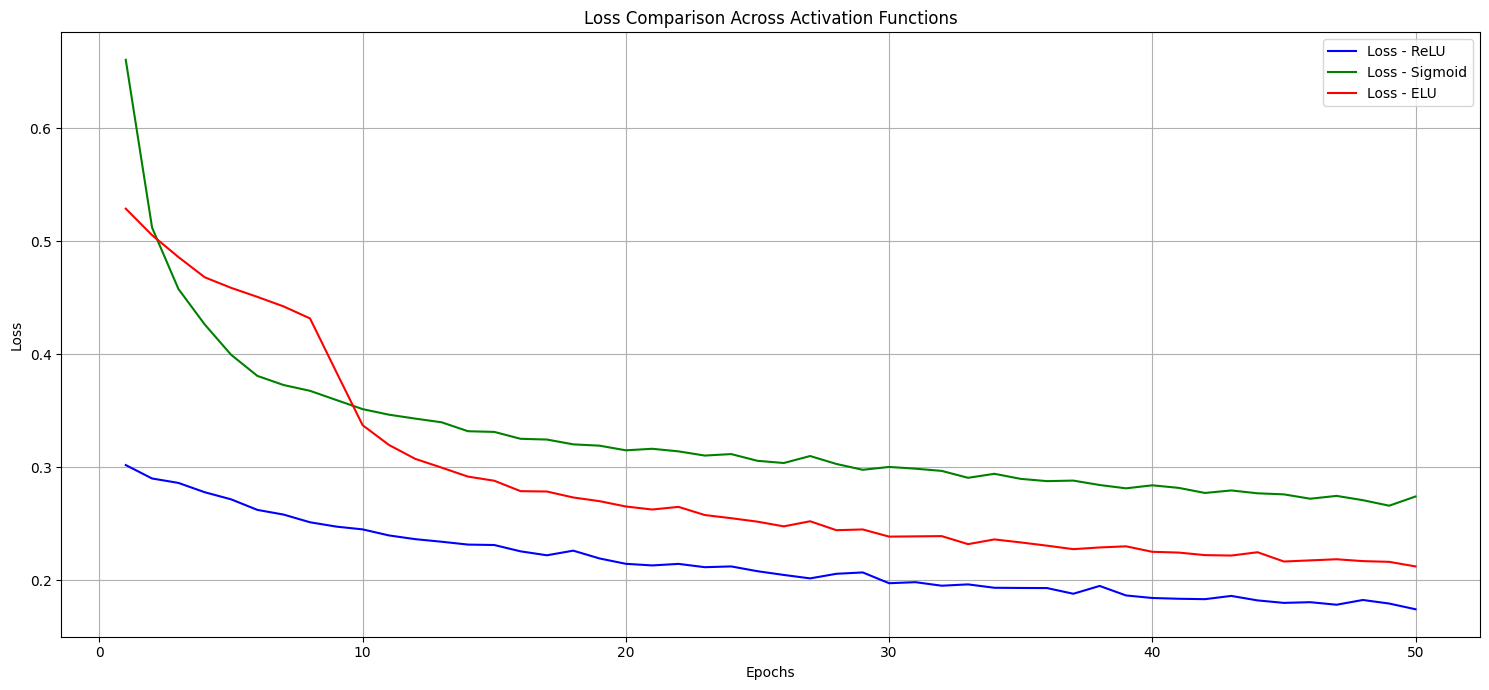

In [149]:
import matplotlib.pyplot as plt
import re

# Function to extract data from a log file
def extract_metrics(log_file):
    epochs = []
    whole_tumor_dice = []
    enhancing_dice = []
    core_dice = []
    losses = []

    with open(log_file, 'r') as file:
        for line in file:
            # Extract epoch number
            epoch_match = re.search(r"Epoch (\d+)", line)
            if epoch_match:
                epoch = int(epoch_match.group(1))
                if len(epochs) == 0 or epoch > epochs[-1]:
                    epochs.append(epoch)

            # Extract Dice scores
            whole_match = re.search(r"Whole Tumor (\d+\.\d+)", line)
            enhancing_match = re.search(r"Enhancing (\d+\.\d+)", line)
            core_match = re.search(r"Core (\d+\.\d+)", line)

            if whole_match and enhancing_match and core_match:
                whole_tumor_dice.append(float(whole_match.group(1)))
                enhancing_dice.append(float(enhancing_match.group(1)))
                core_dice.append(float(core_match.group(1)))

            # Extract loss
            loss_match = re.search(r"Average loss: (\d+\.\d+)", line)
            if loss_match:
                losses.append(float(loss_match.group(1)))

    # Ensure all lists have the same length by truncating to the shortest list
    min_length = min(len(epochs), len(whole_tumor_dice), len(enhancing_dice), len(core_dice), len(losses))
    return (
        epochs[:min_length],
        whole_tumor_dice[:min_length],
        enhancing_dice[:min_length],
        core_dice[:min_length],
        losses[:min_length],
    )
pathLogs= "D:/thesis/Final/batchDemo models/"

log_files = {
    "ReLU": pathLogs+"model_ReLU_LOG.txt",
    # "Leaky ReLU": pathLogs+"model_LEAKYRELU_LOG.txt",
    # "PReLU": pathLogs+"model_PRELU_LOG.txt",
    # "ReLU6": pathLogs+"model_relu6_LOG.txt",
    "Sigmoid": pathLogs+"model_sigmoid_LOG.txt",
    "ELU": pathLogs+"model_elu_LOG.txt",
    # "Tanh": pathLogs+"model_TANH_LOG.txt",
    # "CELU": pathLogs+"model_celu_LOG.txt"
}


# Colors for each activation function
colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]

# Plot Dice scores for Whole Tumor, Enhancing Tumor, and Core
plt.figure(figsize=(15, 10))
for (activation, file), color in zip(log_files.items(), colors):
    epochs, whole_dice, enhancing_dice, core_dice, _ = extract_metrics(file)

    if len(epochs) == len(whole_dice):
        plt.plot(epochs, whole_dice, label=f"Whole Tumor - {activation}", linestyle="-", color=color)
    if len(epochs) == len(enhancing_dice):
        plt.plot(epochs, enhancing_dice, label=f"Enhancing Tumor - {activation}", linestyle="--", color=color)
    if len(epochs) == len(core_dice):
        plt.plot(epochs, core_dice, label=f"Core - {activation}", linestyle=":", color=color)

plt.title("Dice Score Comparison Across Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss trends
plt.figure(figsize=(15, 7))
for (activation, file), color in zip(log_files.items(), colors):
    epochs, _, _, _, losses = extract_metrics(file)

    if len(epochs) == len(losses):
        plt.plot(epochs, losses, label=f"Loss - {activation}", color=color)

plt.title("Loss Comparison Across Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import torch
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImaged, EnsureTyped, SpatialPadd
from monai.utils import ensure_tuple_rep

# Custom AddChannelD transform
class AddChannelD:
    def __init__(self, keys):
        self.keys = keys
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = d[key][None, ...]  # Add channel axis at the start
        return d

# Define paths
model_name = "ReLU"
test_sample_path = {
    "t1": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1.nii",
    "t2": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t2.nii",
    "t1ce": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii",
    "flair": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii",
    "seg": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii",
}

# Define transforms
keys = ["t1", "t2", "t1ce", "flair", "seg"]
spatial_size = ensure_tuple_rep(160, 3)  # Ensures spatial_size is 3D

test_transforms = Compose([
    LoadImaged(keys=keys),
    AddChannelD(keys=keys),  # Add channel dimension manually
    SpatialPadd(keys=keys, spatial_size=spatial_size),  # Pad to correct size
    EnsureTyped(keys=keys),
])

# Apply transforms and debug shapes
transformed_sample = test_transforms(test_sample_path)

# Debugging: Check the shape of loaded and padded data
print(f"Keys in transformed_sample: {list(transformed_sample.keys())}")
print(f"Shape of t1: {transformed_sample['t1'].shape}")
print(f"Type of t1: {type(transformed_sample['t1'])}")


Keys in transformed_sample: ['t1', 't2', 't1ce', 'flair', 'seg']
Shape of t1: torch.Size([1, 240, 240, 160])
Type of t1: <class 'monai.data.meta_tensor.MetaTensor'>


In [24]:
import torch
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImaged, EnsureTyped, CenterSpatialCropd
from monai.utils import ensure_tuple_rep

# Custom AddChannelD transform
class AddChannelD:
    def __init__(self, keys):
        self.keys = keys
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = d[key][None, ...]  # Add channel axis at the start
        return d

# Define paths
model_name = "ReLU"
test_sample_path = {
    "t1": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1.nii",
    "t2": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t2.nii",
    "t1ce": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii",
    "flair": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii",
    "seg": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii",
}

# Define transforms
keys = ["t1", "t2", "t1ce", "flair", "seg"]
test_transforms = Compose([
    LoadImaged(keys=keys),
    AddChannelD(keys=keys),  # Add channel dimension manually
    CenterSpatialCropd(keys=keys, roi_size=(160, 160, 80)),  # Crop to required size
    EnsureTyped(keys=keys),
])

# Apply transforms and debug shapes
transformed_sample = test_transforms(test_sample_path)

# Debugging: Check the shape of loaded and cropped data
print(f"Keys in transformed_sample: {list(transformed_sample.keys())}")
print(f"Shape of t1 after cropping: {transformed_sample['t1'].shape}")



Keys in transformed_sample: ['t1', 't2', 't1ce', 'flair', 'seg']
Shape of t1 after cropping: torch.Size([1, 160, 160, 80])


Processing model with activation: ReLU
Processing model with activation: ReLU6
Processing model with activation: LeakyReLU
Processing model with activation: PReLU


C:\Users\mramr\AppData\Local\Temp\ipykernel_50660\195694312.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Processing model with activation: Tanh
Processing model with activation: Sigmoid
Processing model with activation: ELU
Processing model with activation: CELU


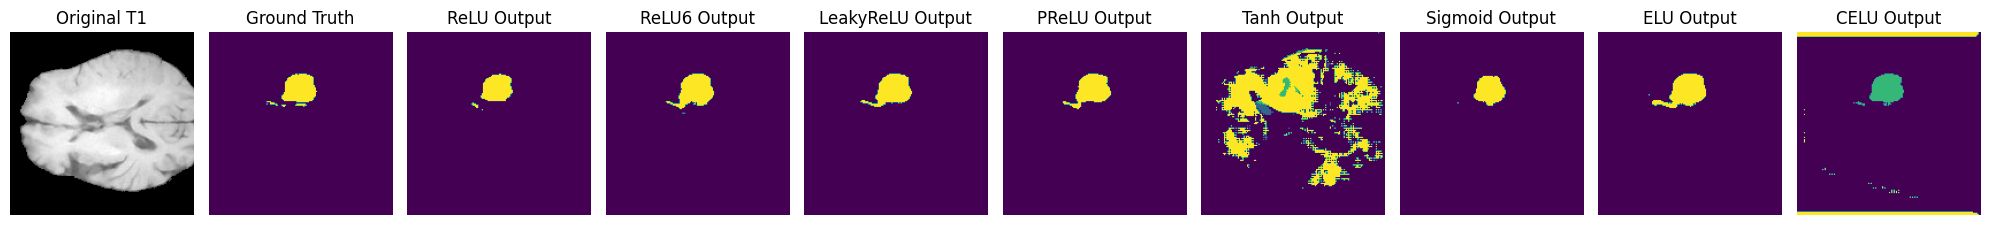

In [31]:
import torch
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImaged, EnsureTyped, CenterSpatialCropd
from monai.utils import ensure_tuple_rep

# Custom AddChannelD transform
class AddChannelD:
    def __init__(self, keys):
        self.keys = keys
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = d[key][None, ...]  # Add channel axis at the start
        return d

# Define paths
activations = ["ReLU", "ReLU6", "LeakyReLU", "PReLU", "Tanh", "Sigmoid", "ELU", "CELU"]
model_dir = "D:/thesis/Final/batchDemo models/"
test_sample_path = {
    "t1": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1.nii",
    "t2": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t2.nii",
    "t1ce": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii",
    "flair": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii",
    "seg": "D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii",
}

# Define transforms
keys = ["t1", "t2", "t1ce", "flair", "seg"]
test_transforms = Compose([
    LoadImaged(keys=keys),
    AddChannelD(keys=keys),  # Add channel dimension manually
    CenterSpatialCropd(keys=keys, roi_size=(160, 160, 80)),  # Crop to required size
    EnsureTyped(keys=keys),
])

# Apply transforms
transformed_sample = test_transforms(test_sample_path)

# Prepare input tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = torch.cat([
    transformed_sample["t1"],
    transformed_sample["t2"],
    transformed_sample["t1ce"],
    transformed_sample["flair"]
], dim=0).unsqueeze(0).to(device)  # Shape: (1, 4, 160, 160, 80)

# Visualization
slice_index = inputs.shape[-1] // 2  # Middle slice for visualization
ground_truth = transformed_sample["seg"][0, :, :, slice_index]

# Initialize results storage
results = {}

# Perform inference for each activation function
for activation in activations:
    print(f"Processing model with activation: {activation}")
    model_path = f"{model_dir}/{activation}/model_{activation}_epoch_50.pth"
    
    # Define and load the model
    model = UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=4,
        channels=(16, 32, 64, 128),
        strides=(1, 2, 2, 2),
        kernel_size=3,
        act=activation,
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(inputs)  # Shape: (1, num_classes, 160, 160, 80)
        outputs = torch.softmax(outputs, dim=1)  # Apply softmax for probabilities
        predicted_segmentation = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()  # Get predicted class labels

    # Store the results
    results[activation] = predicted_segmentation[:, :, slice_index]

# Visualization of Results
plt.figure(figsize=(20, 10))
cols = len(activations) + 2

# Display original T1 image
plt.subplot(1, cols, 1)
plt.imshow(transformed_sample["t1"][0, :, :, slice_index], cmap="gray")
plt.title("Original T1")
plt.axis("off")

# Display ground truth
plt.subplot(1, cols, 2)
plt.imshow(ground_truth, cmap="viridis")
plt.title("Ground Truth")
plt.axis("off")

# Display predicted segmentations
for i, activation in enumerate(activations):
    plt.subplot(1, cols, i + 3)
    plt.imshow(results[activation], cmap="viridis")
    plt.title(f"{activation} Output")
    plt.axis("off")

plt.tight_layout()
plt.show()


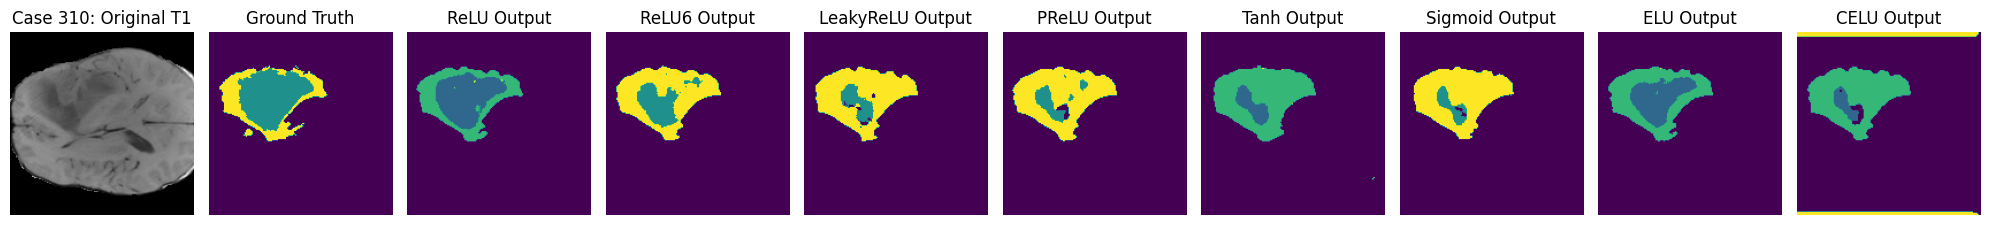

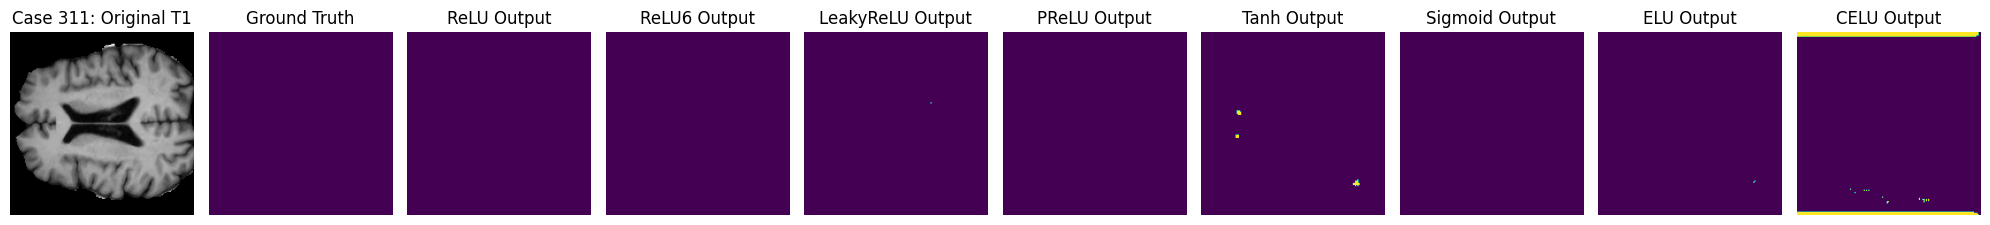

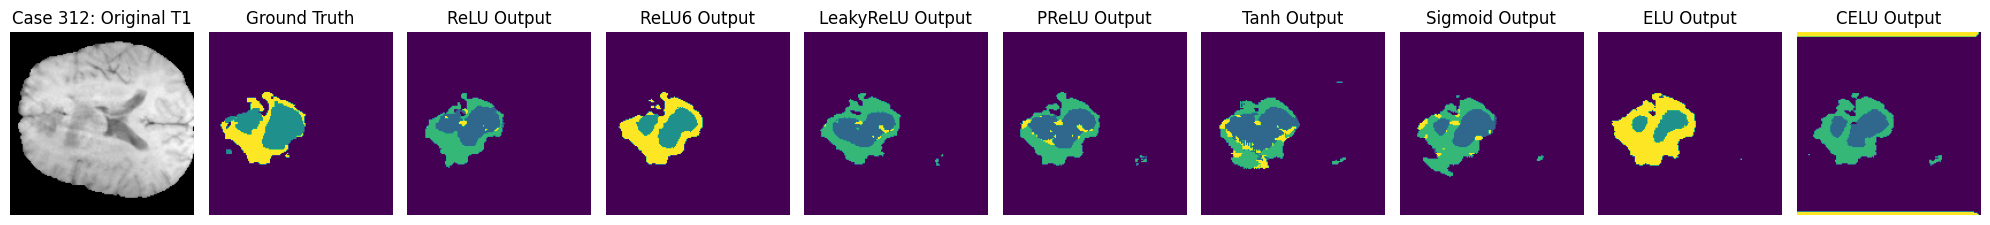

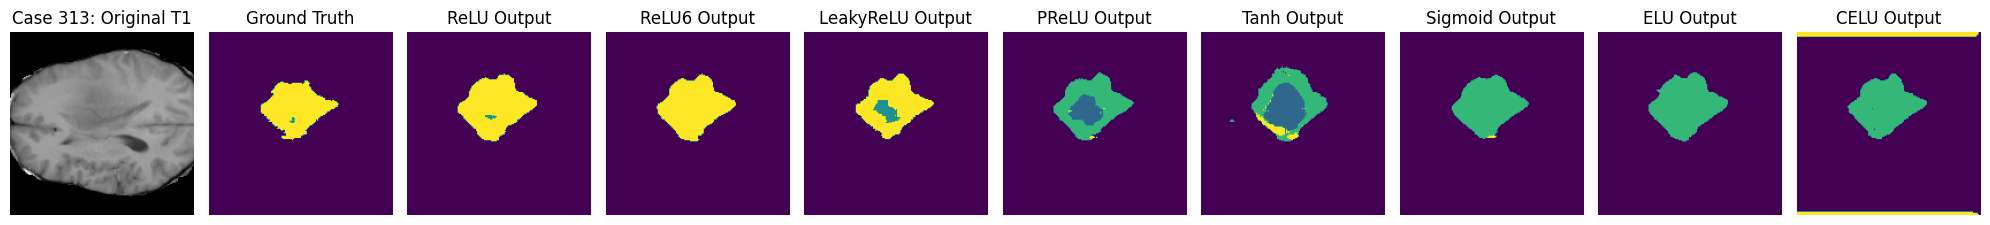

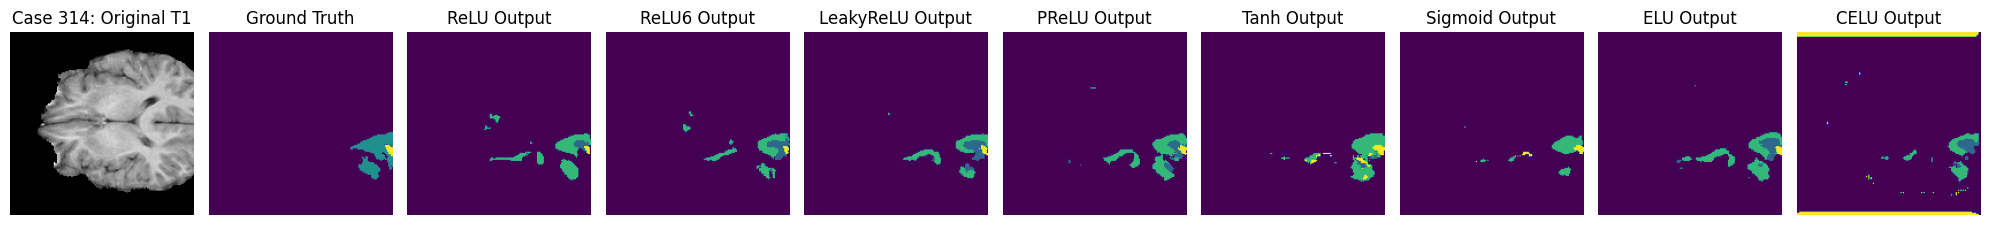

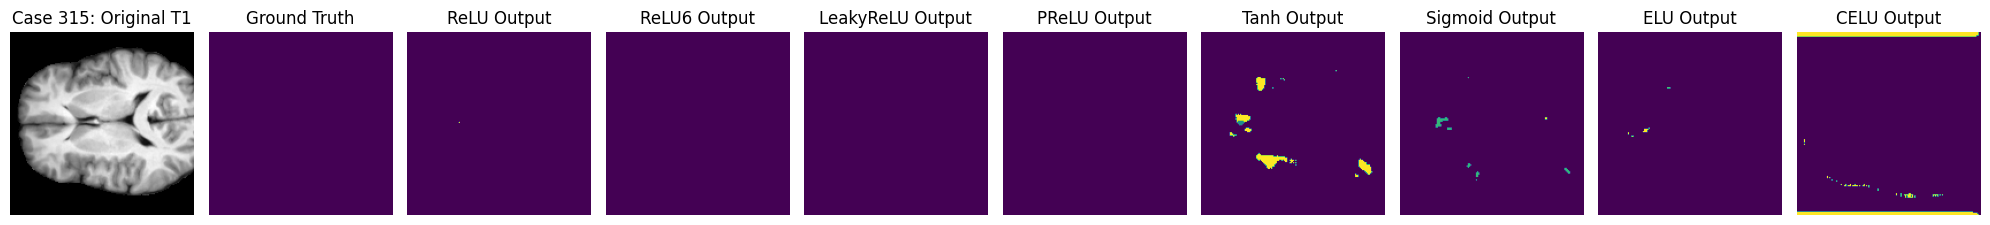

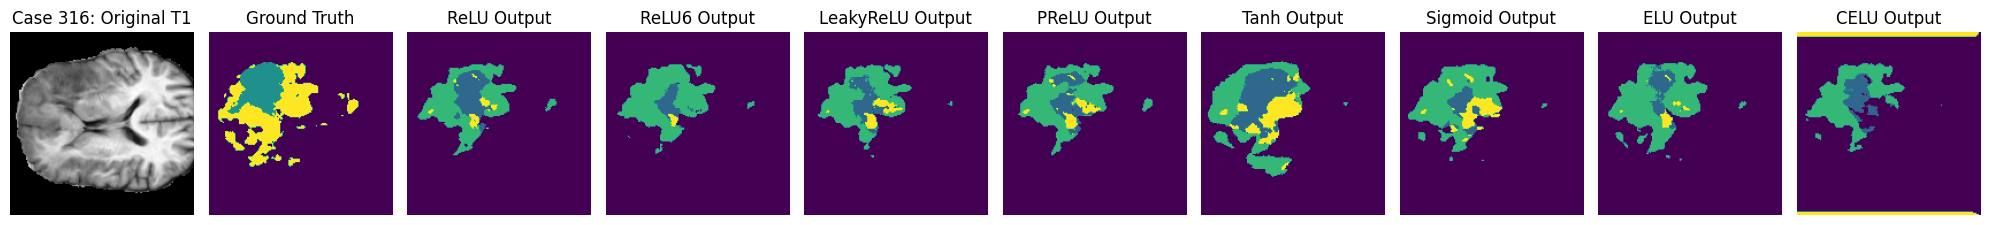

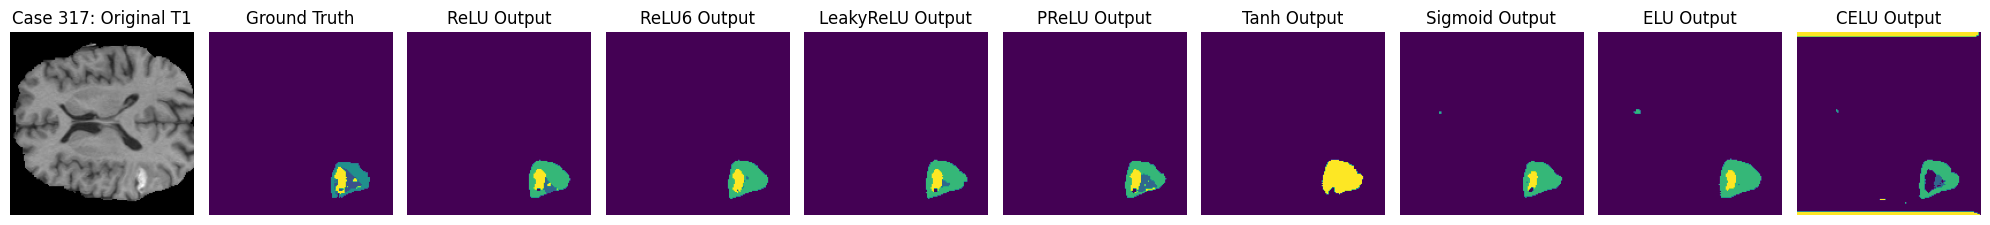

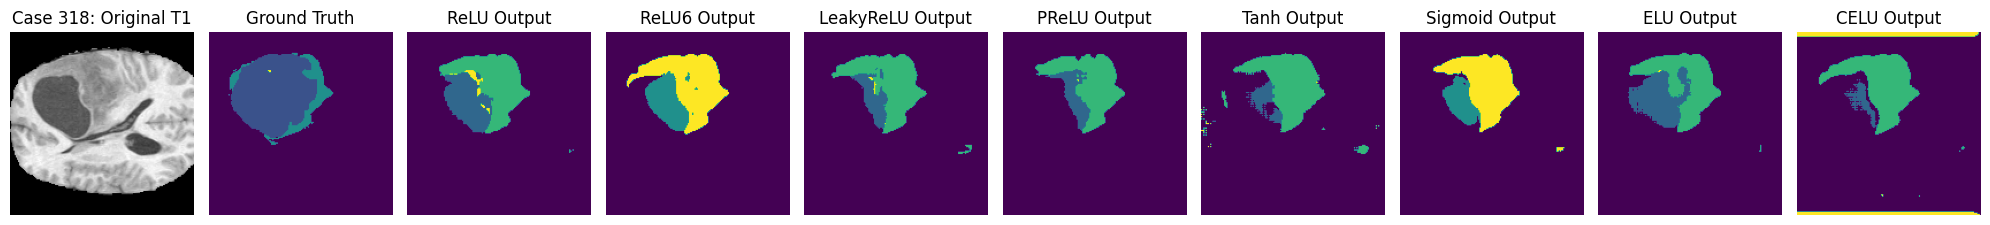

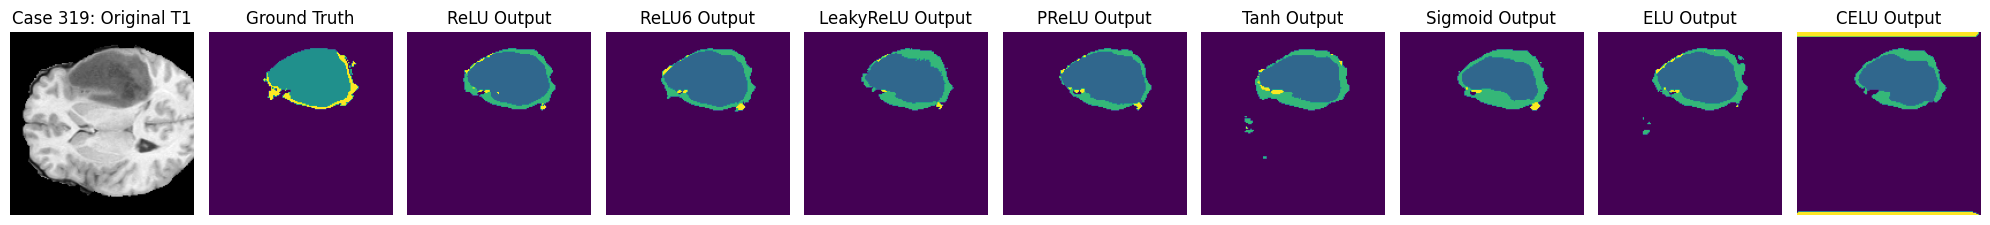

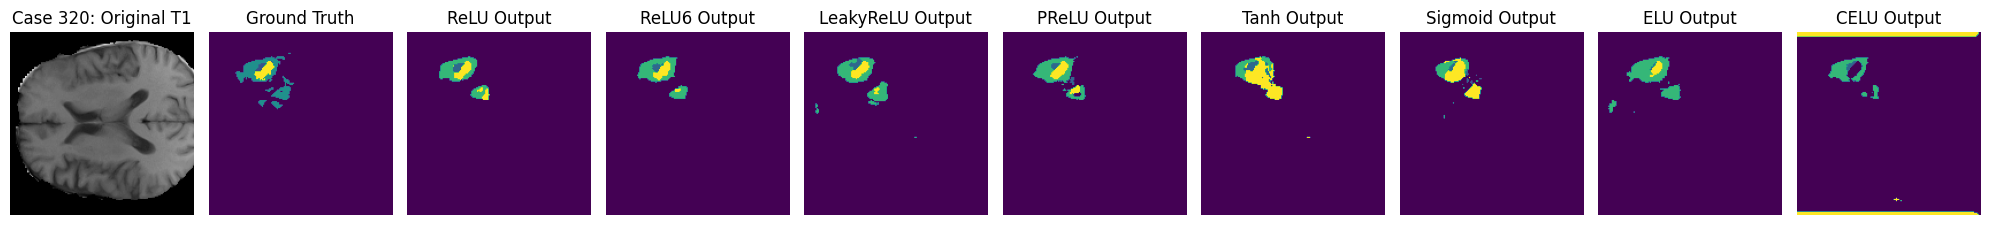

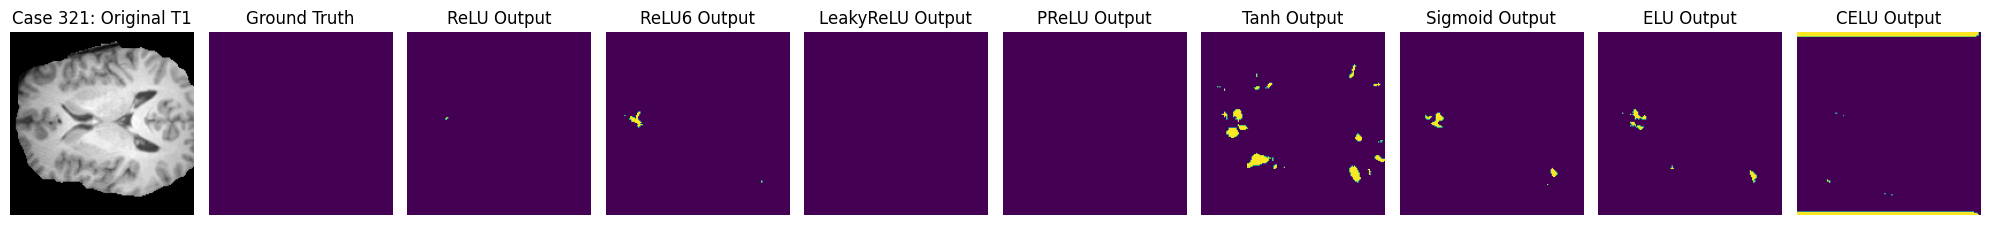

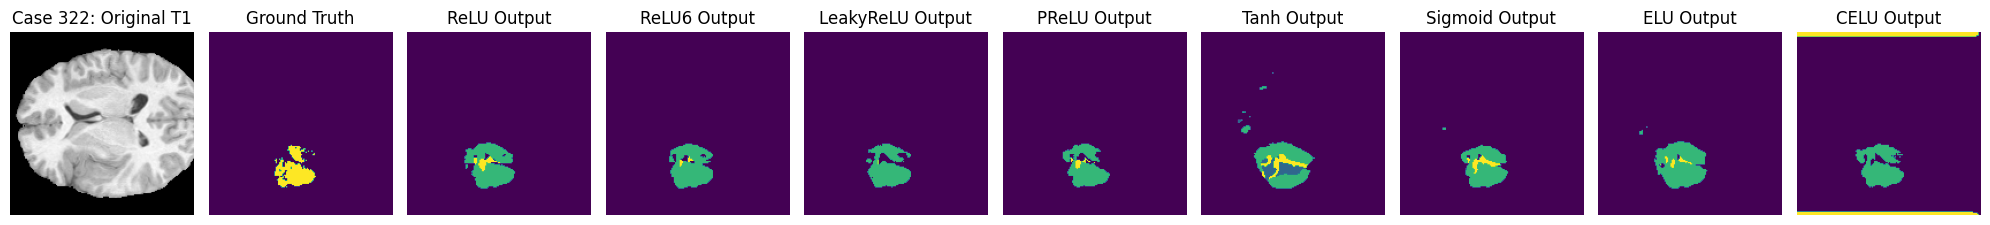

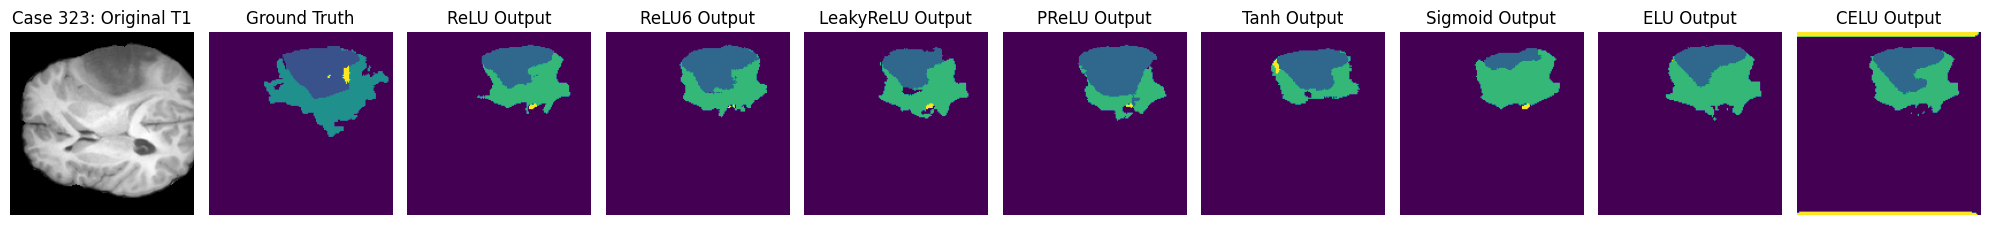

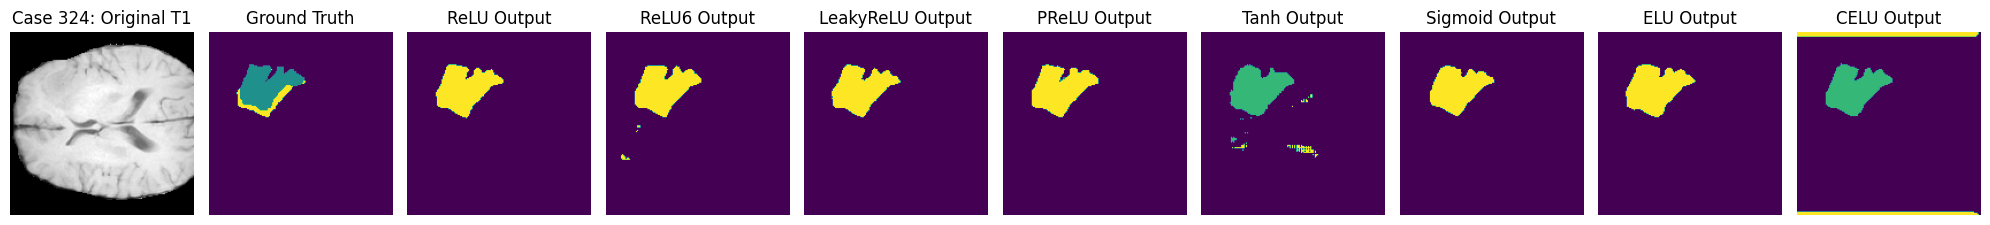

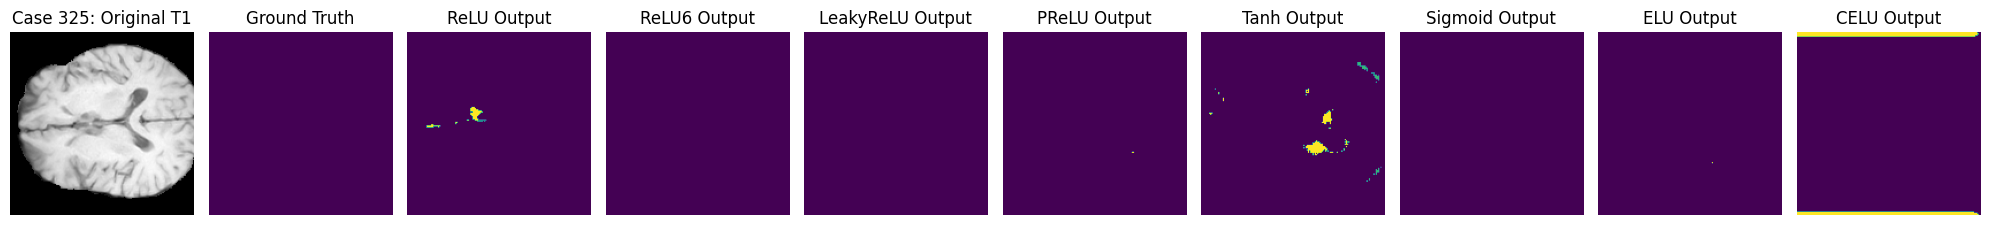

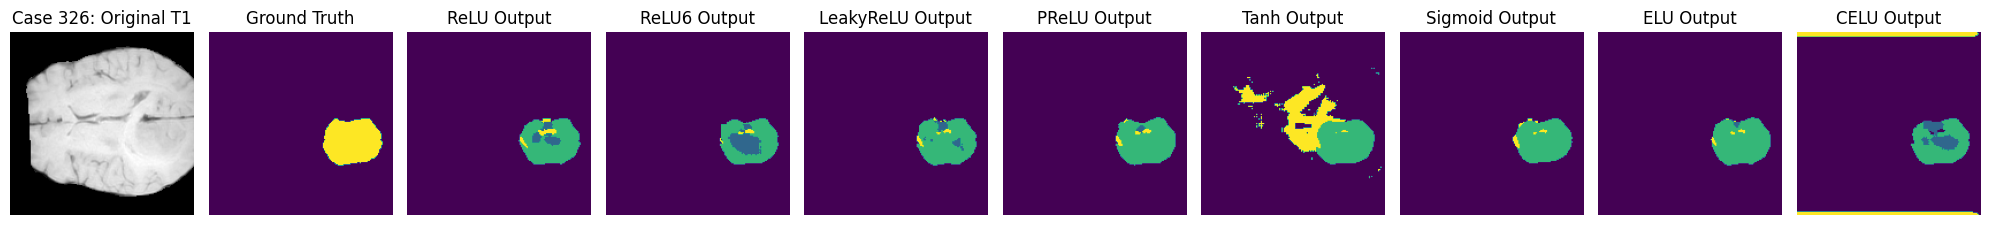

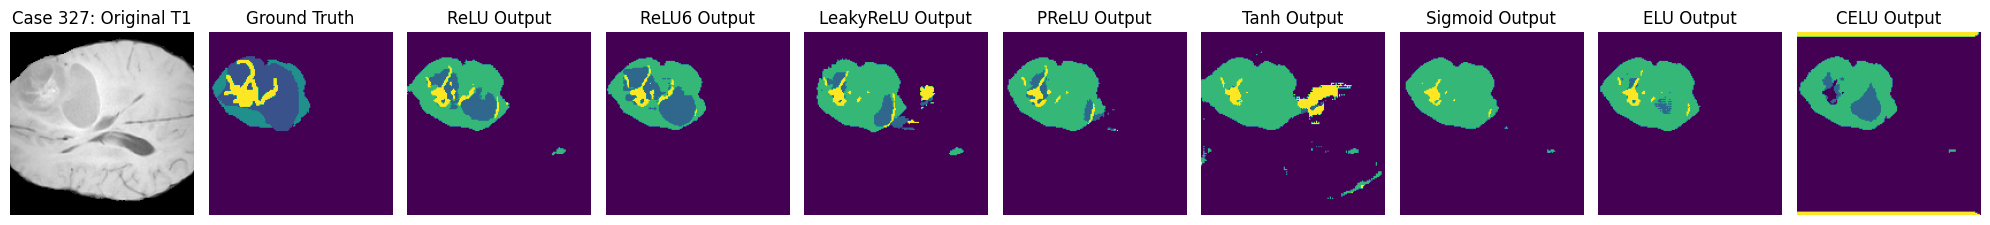

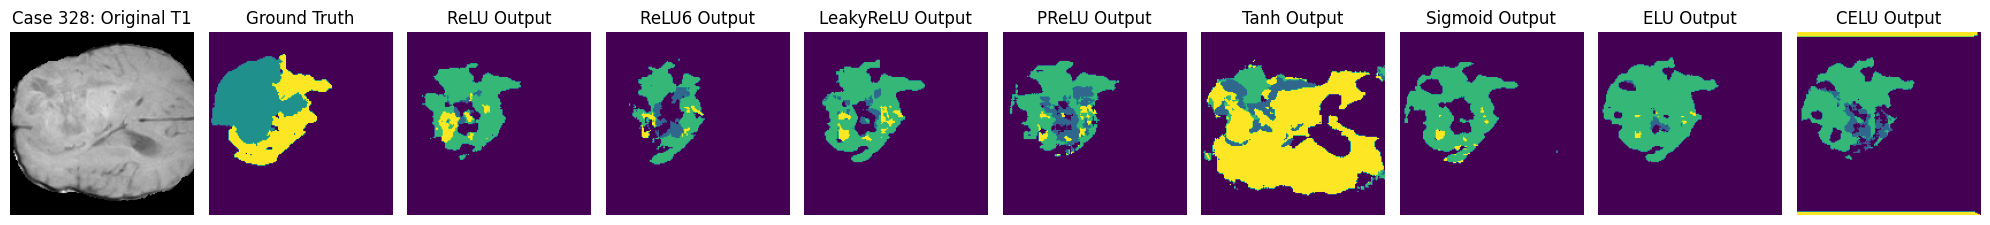

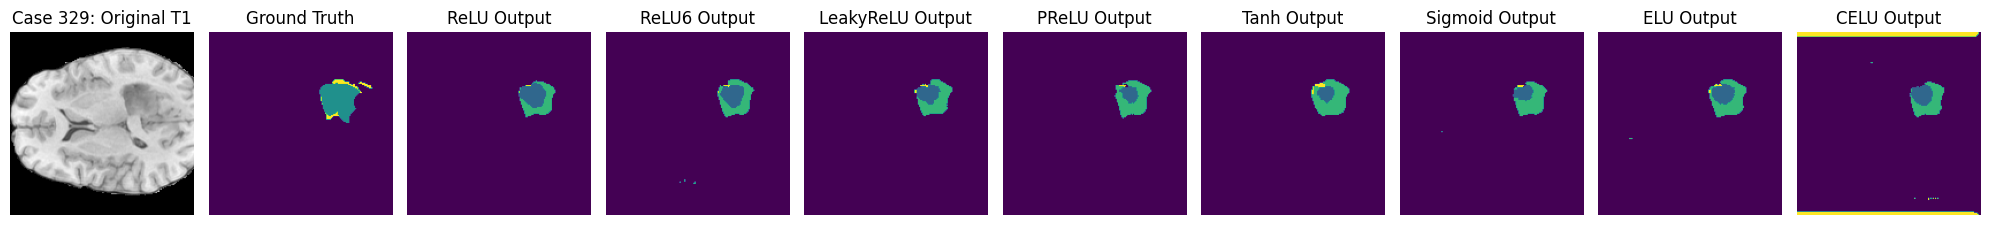

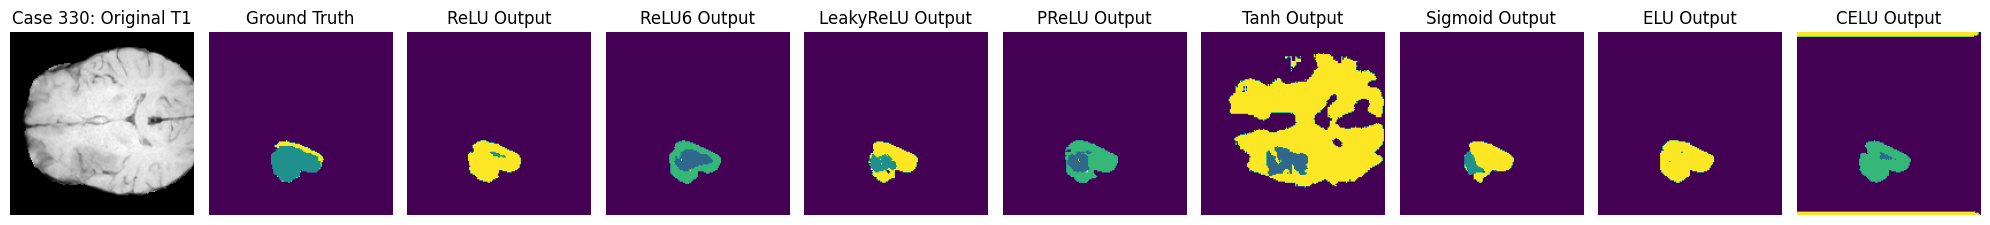

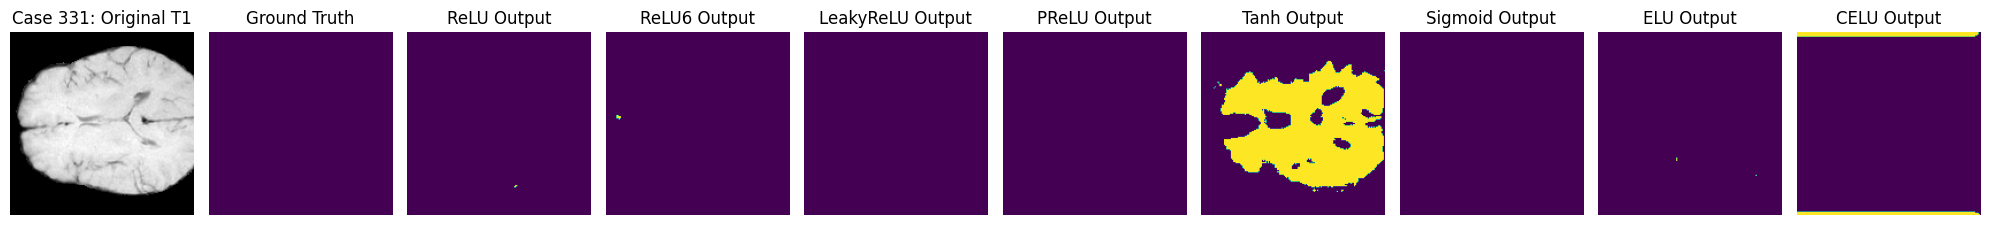

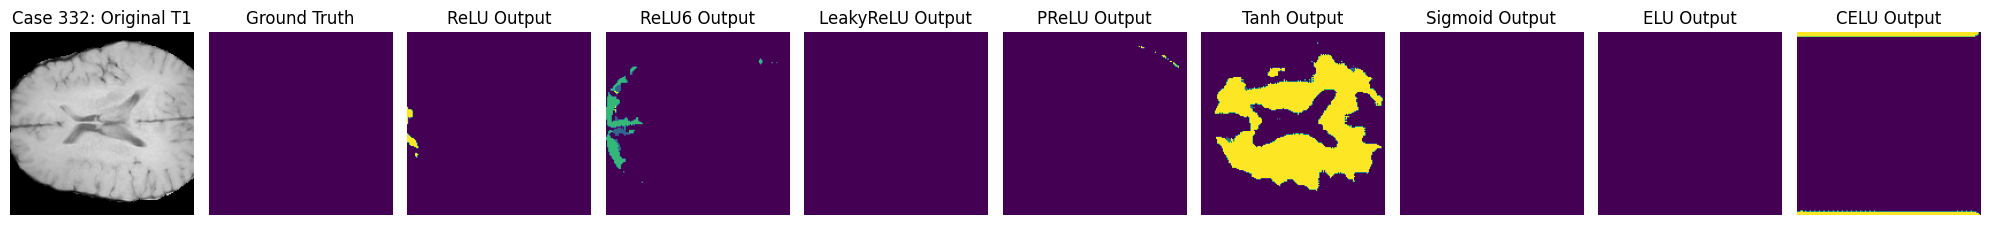

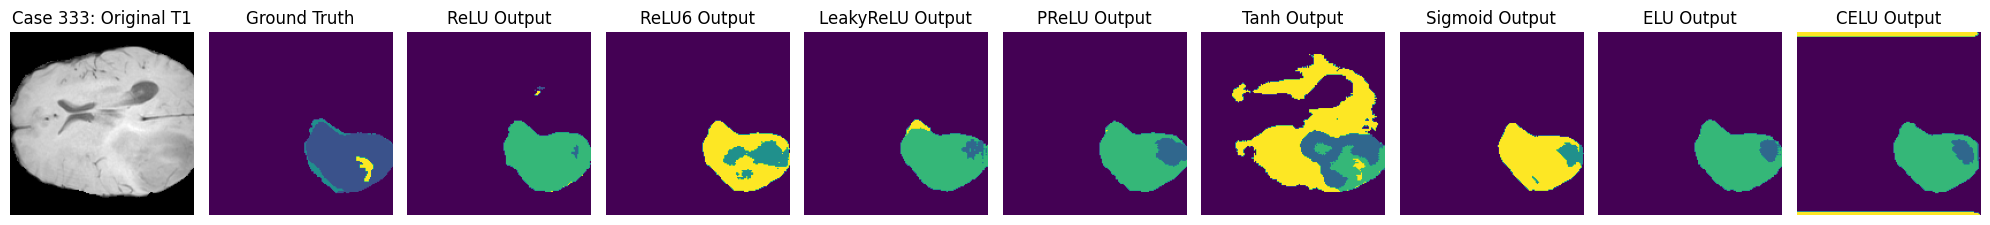

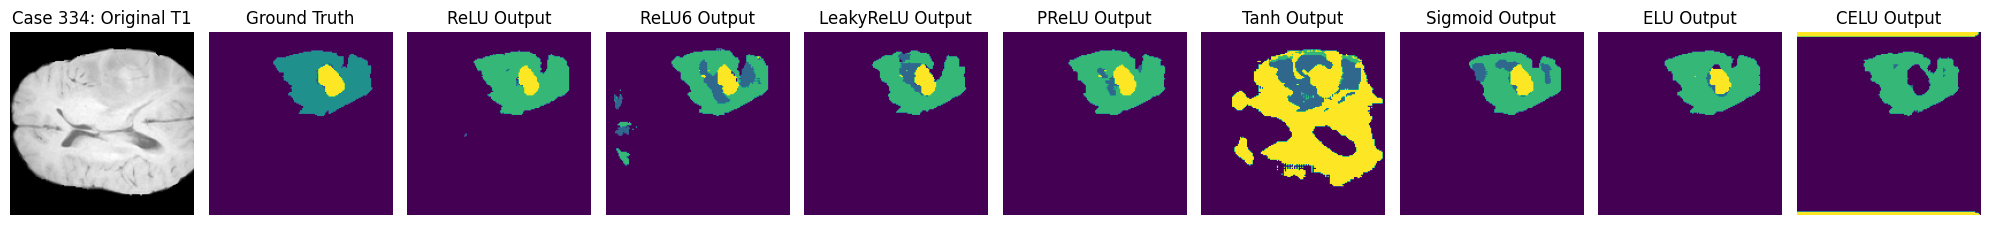

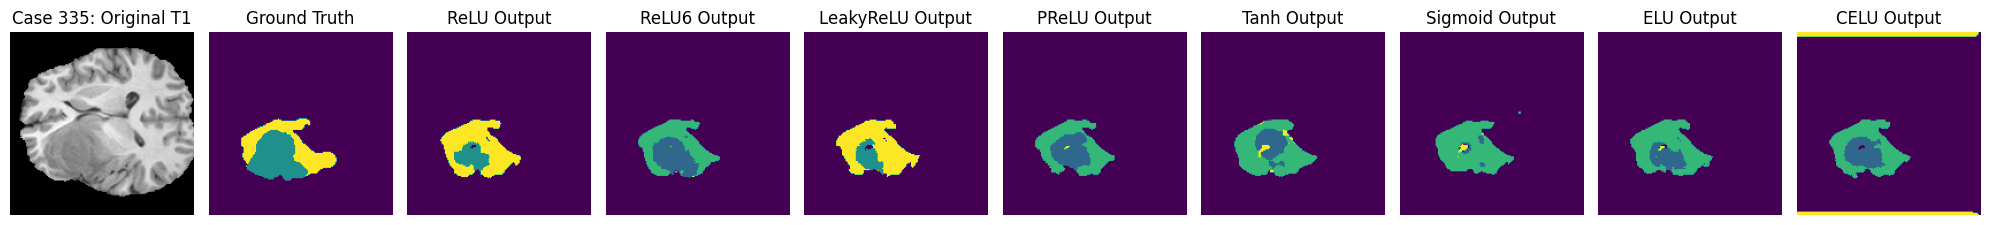

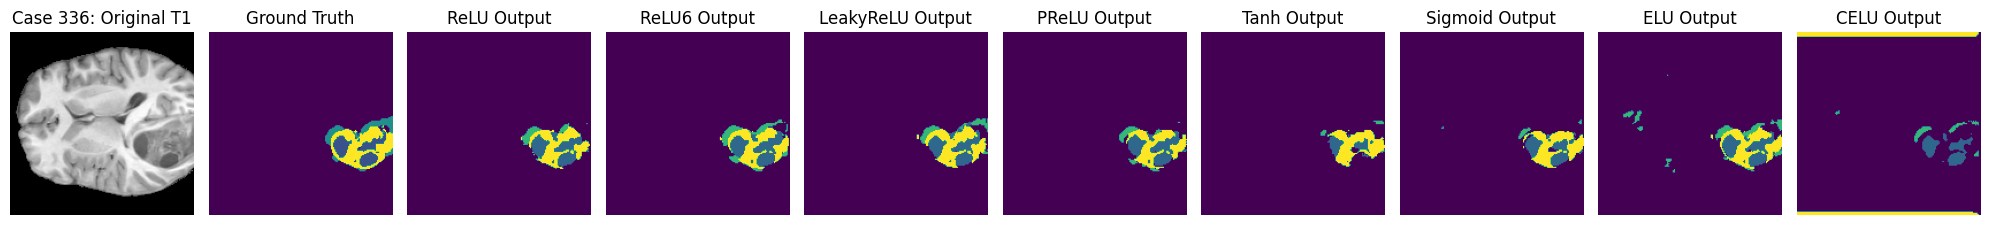

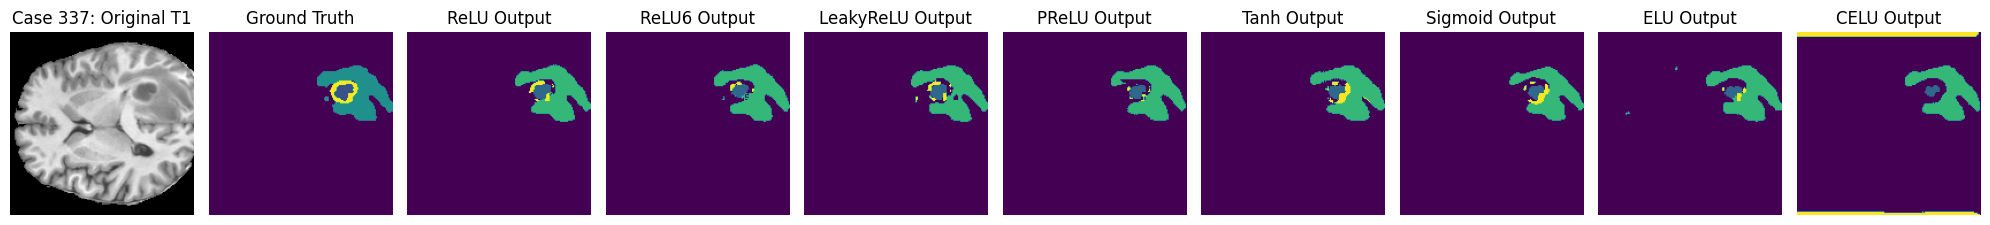

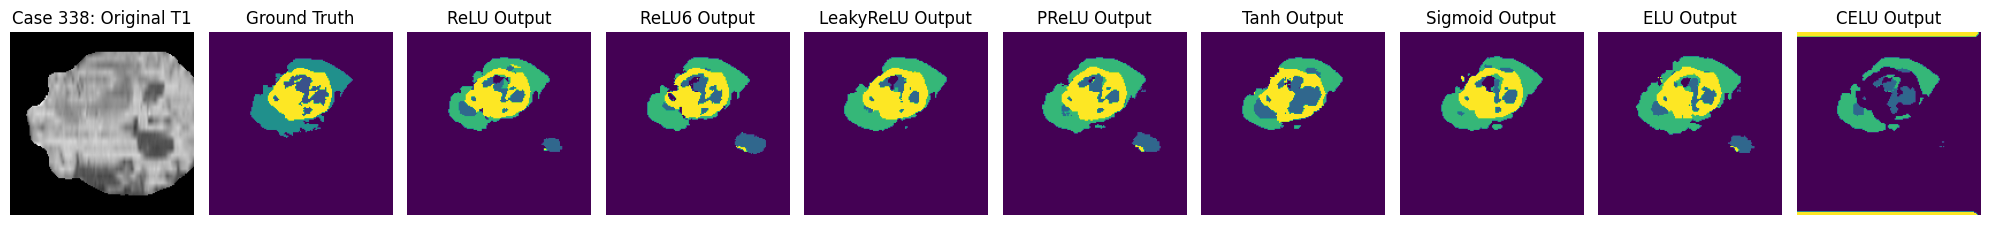

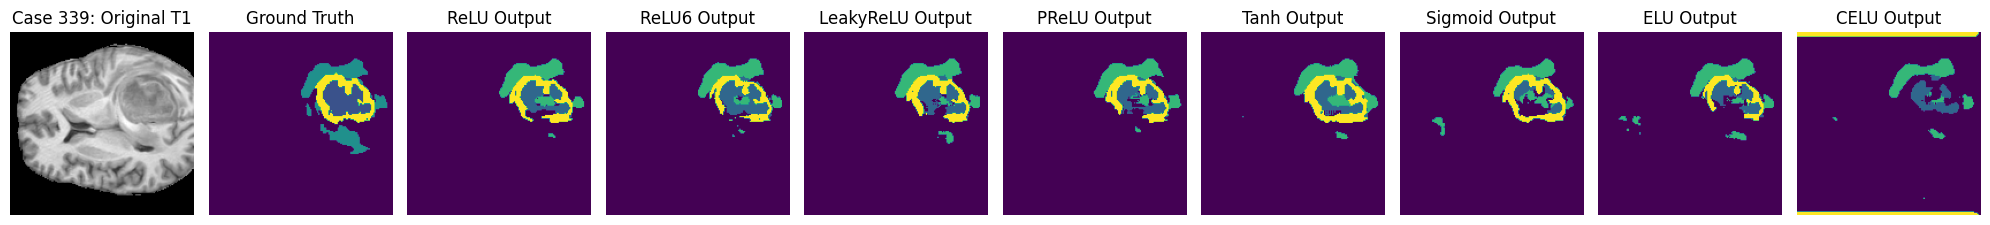

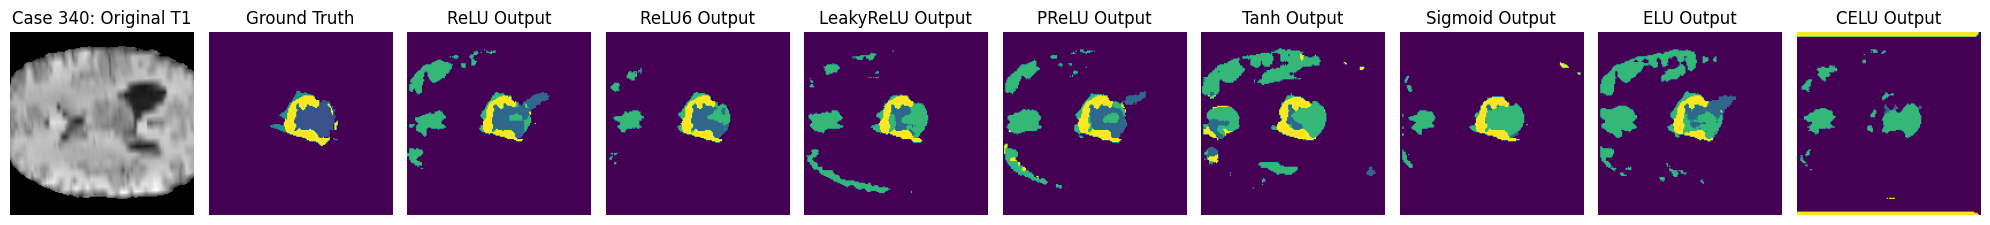

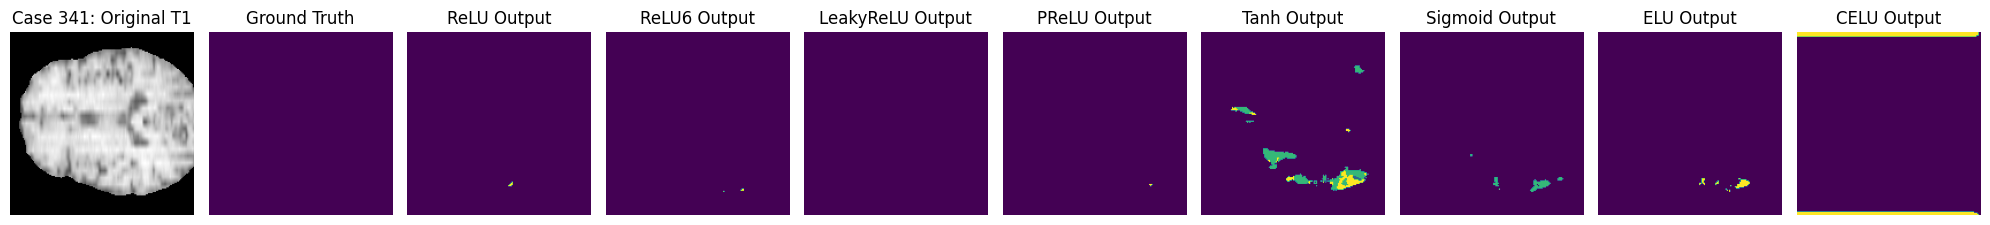

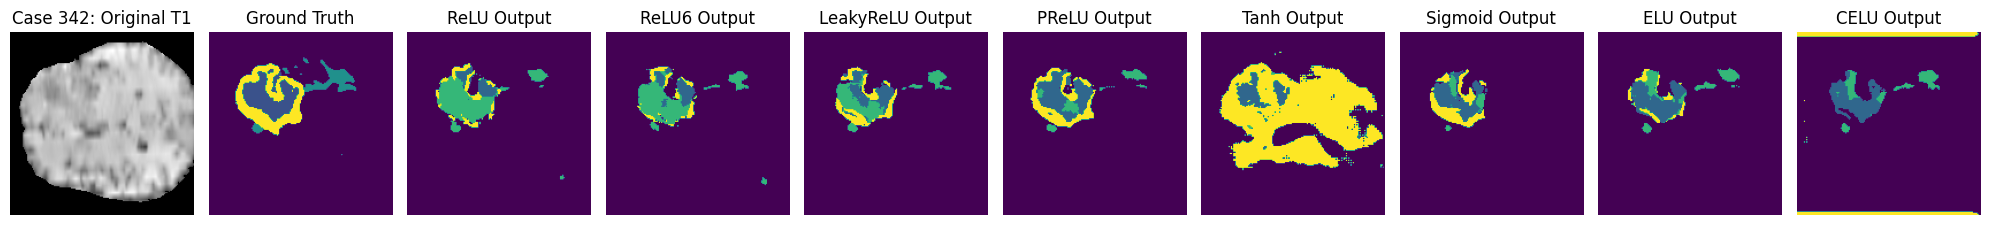

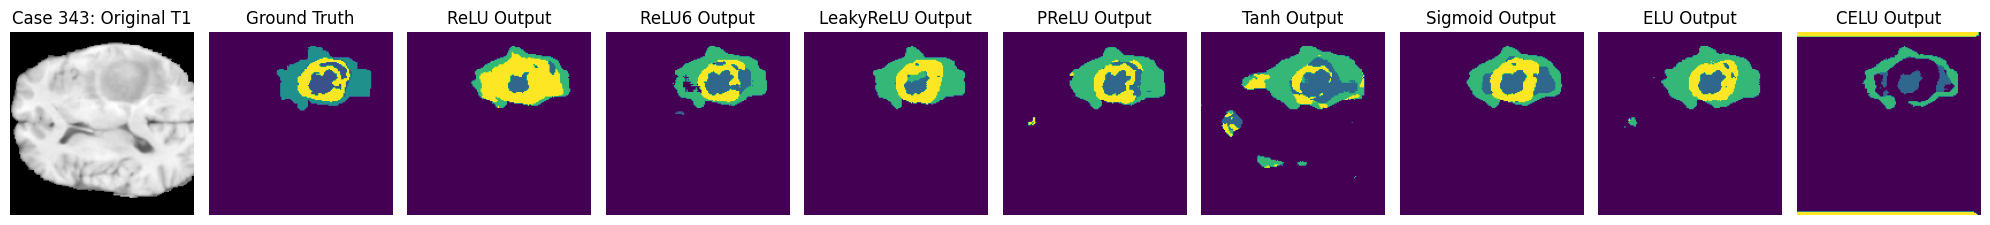

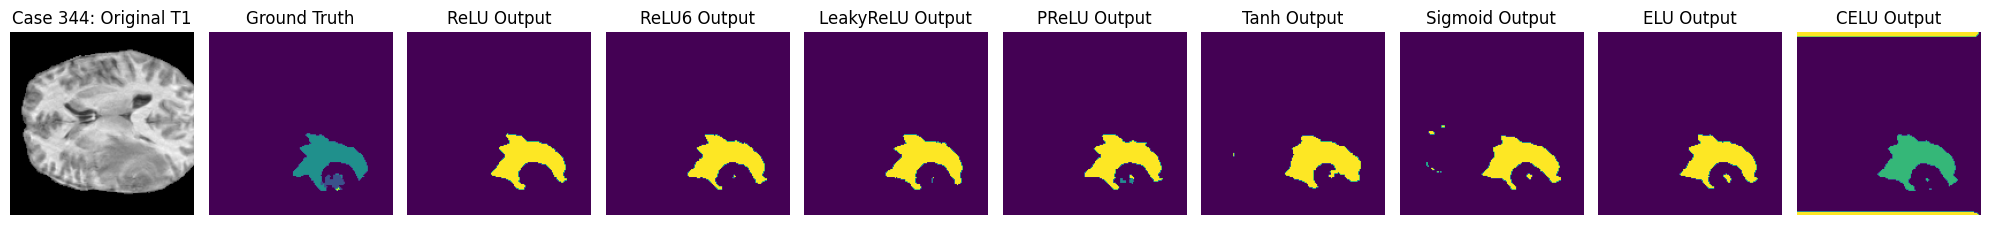

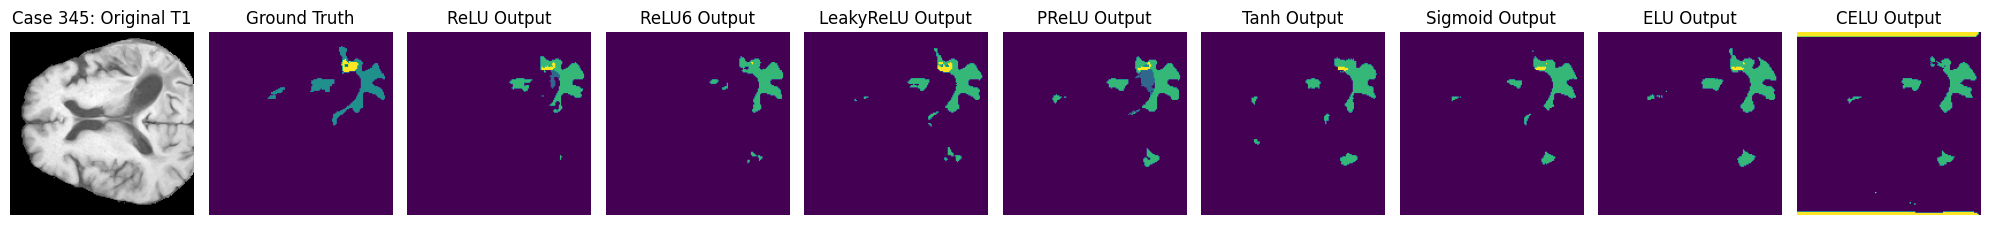

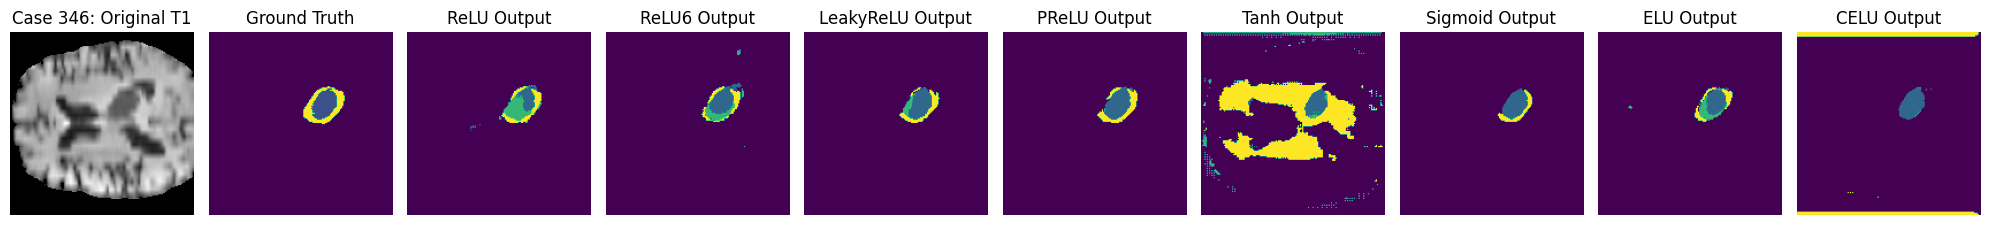

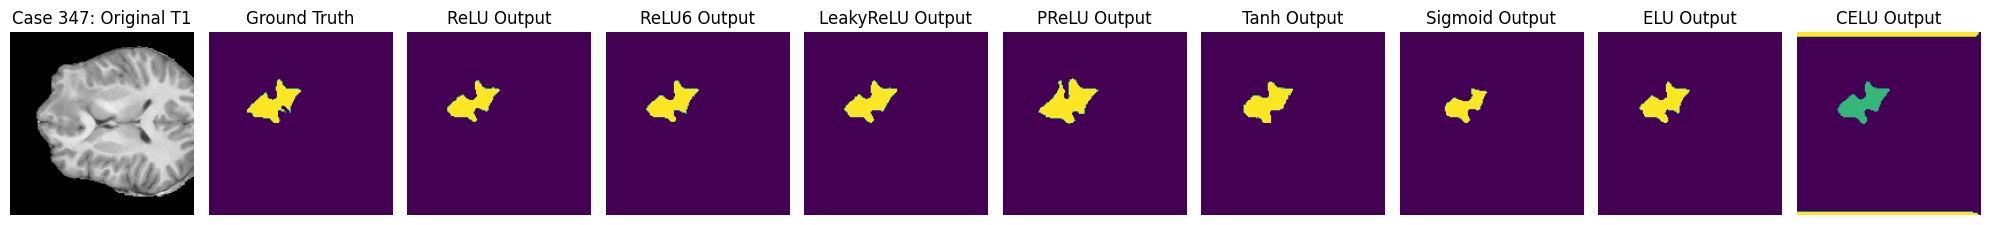

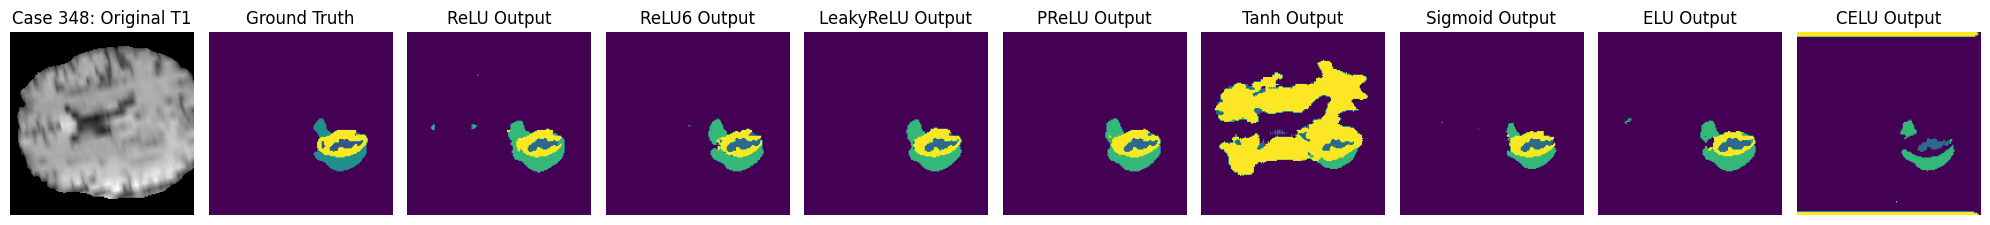

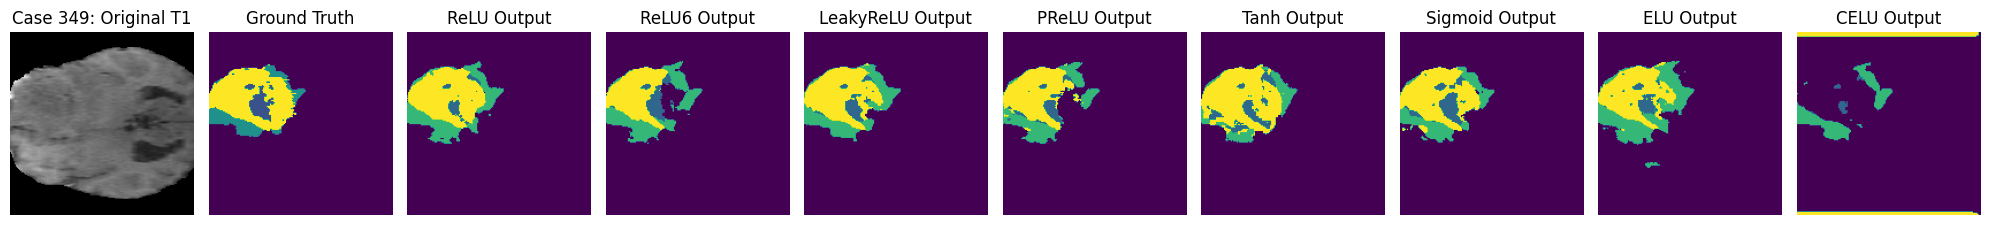

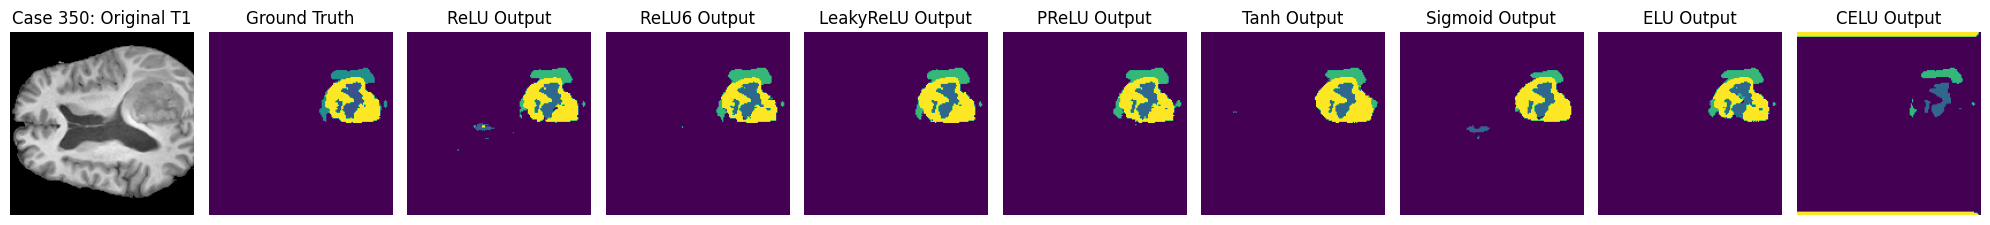

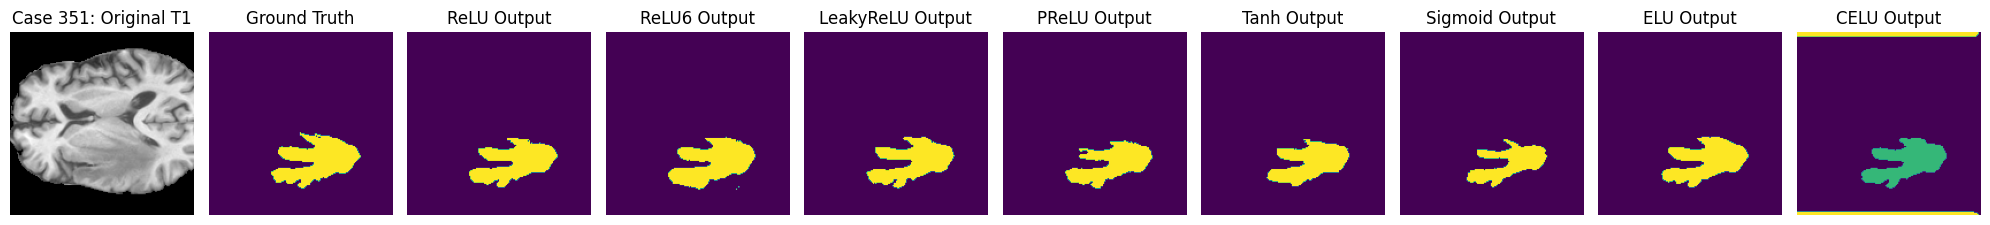

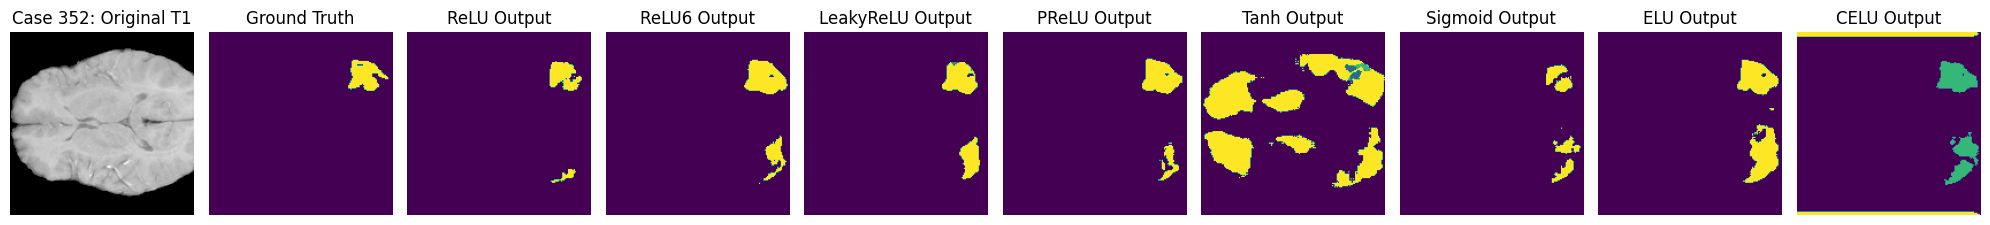

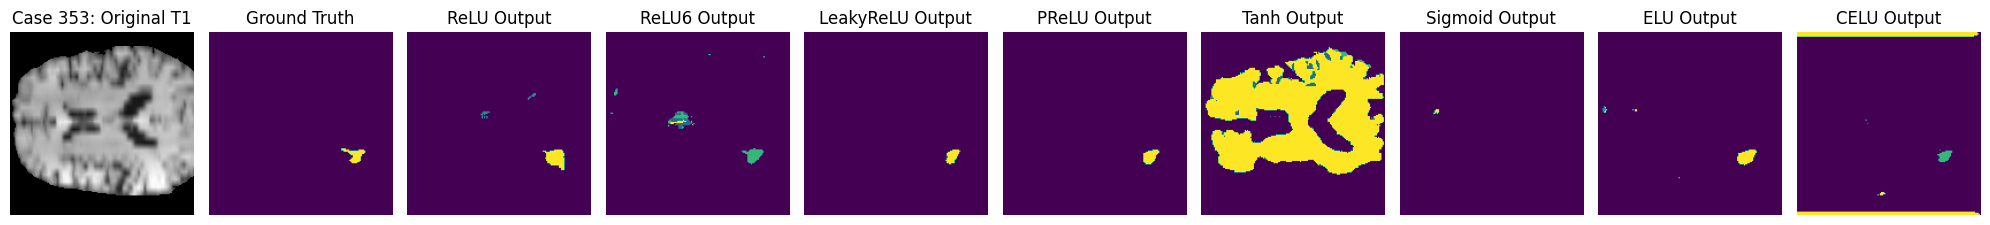

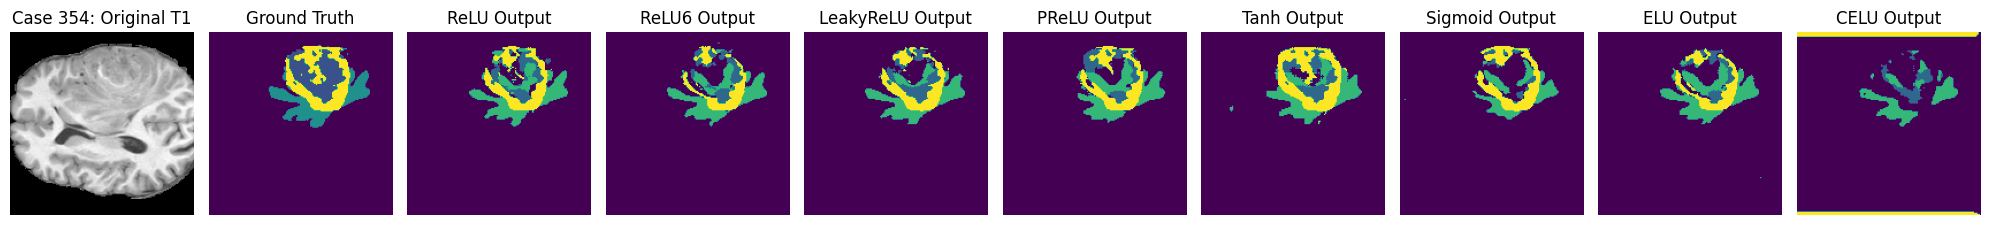

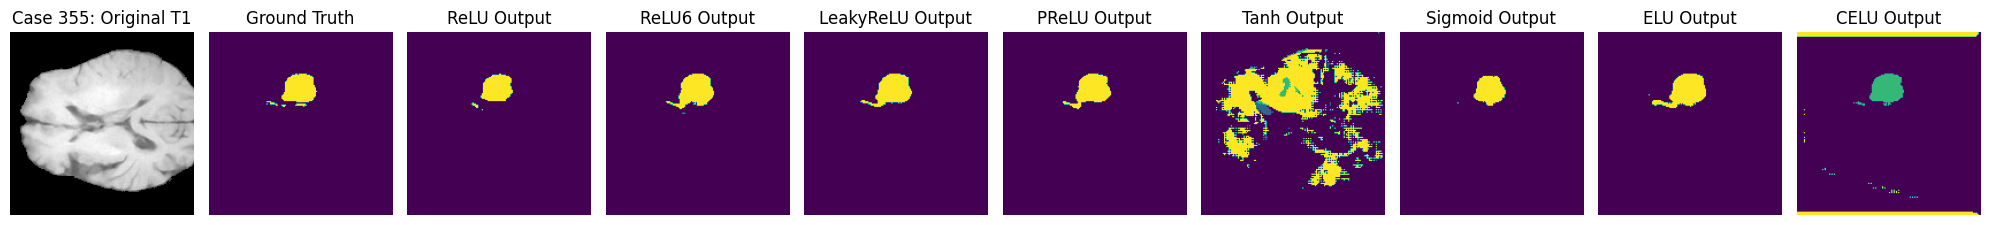

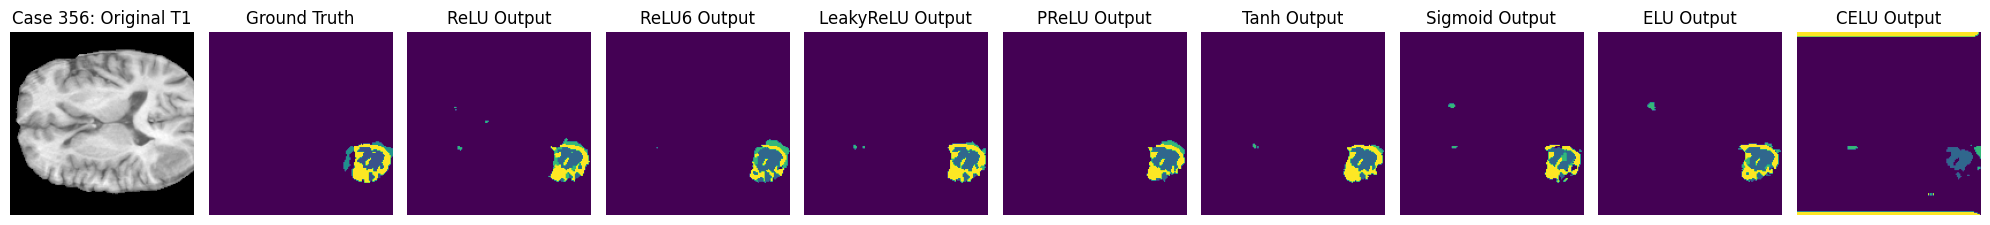

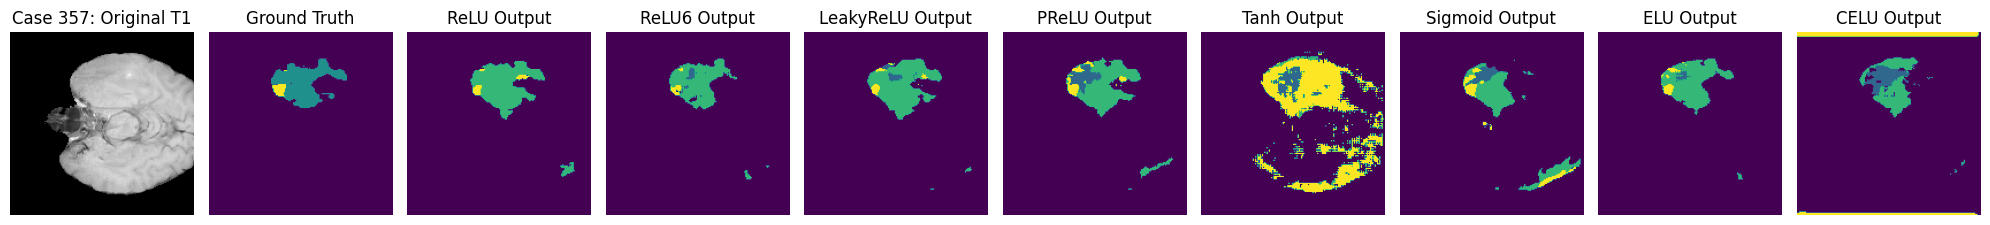

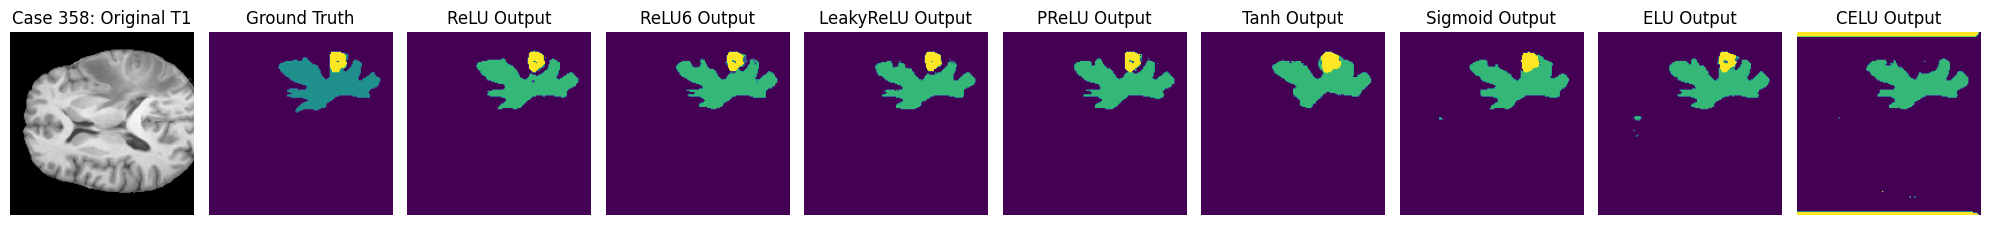

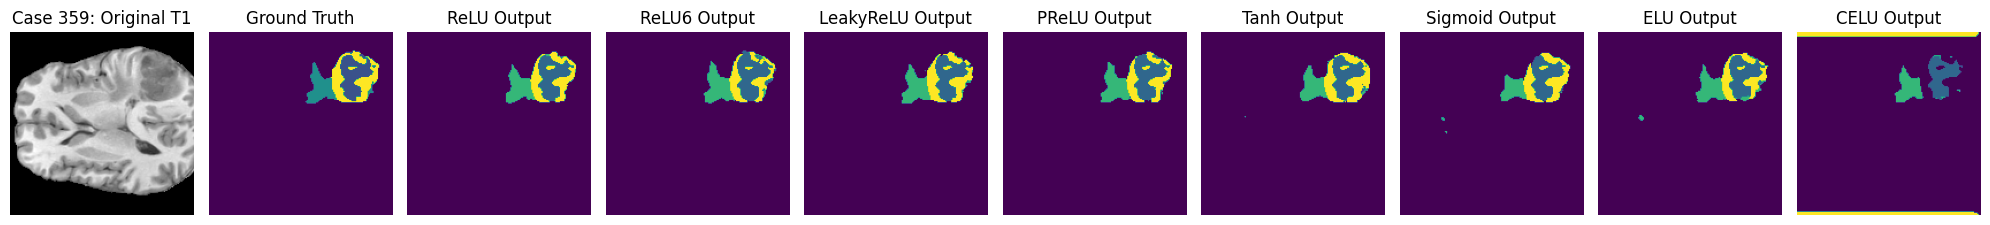

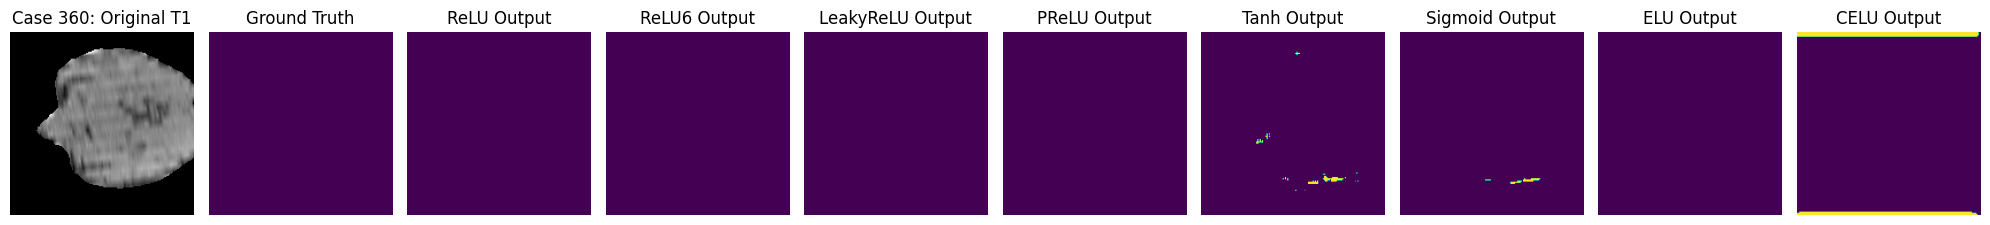

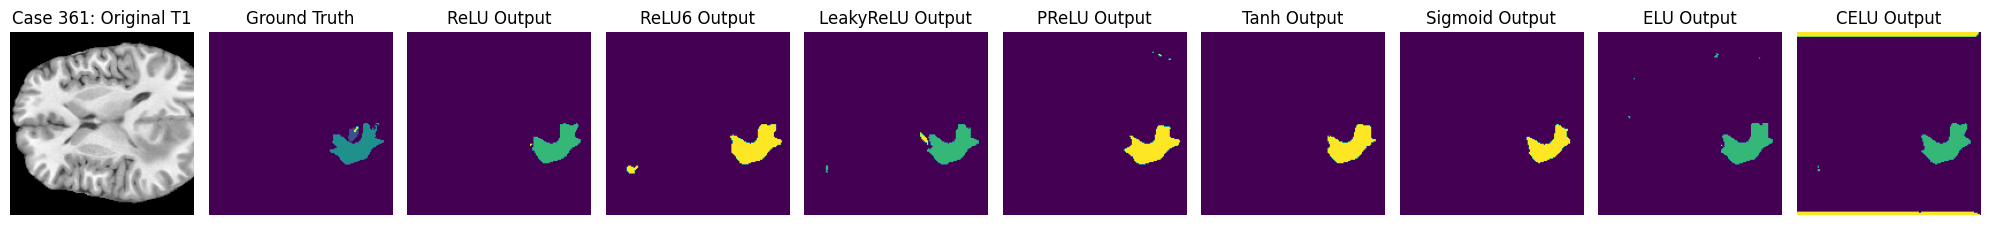

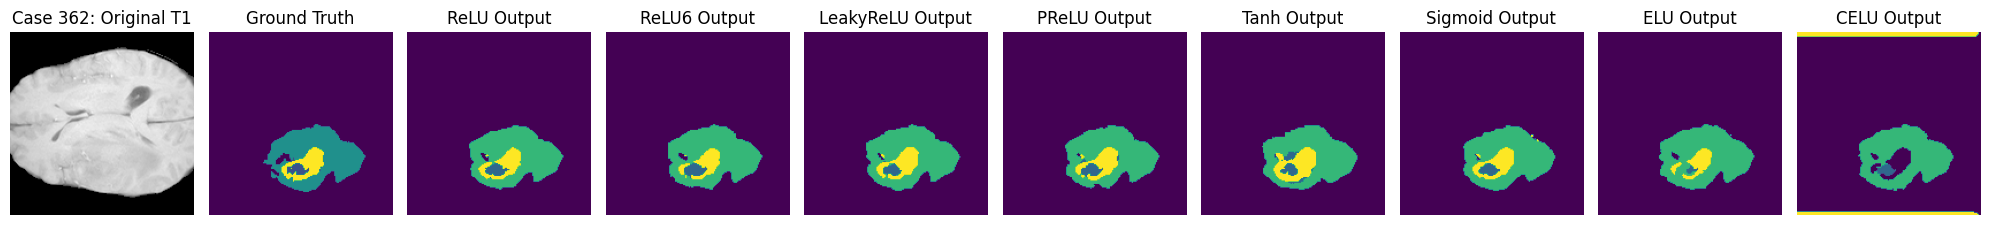

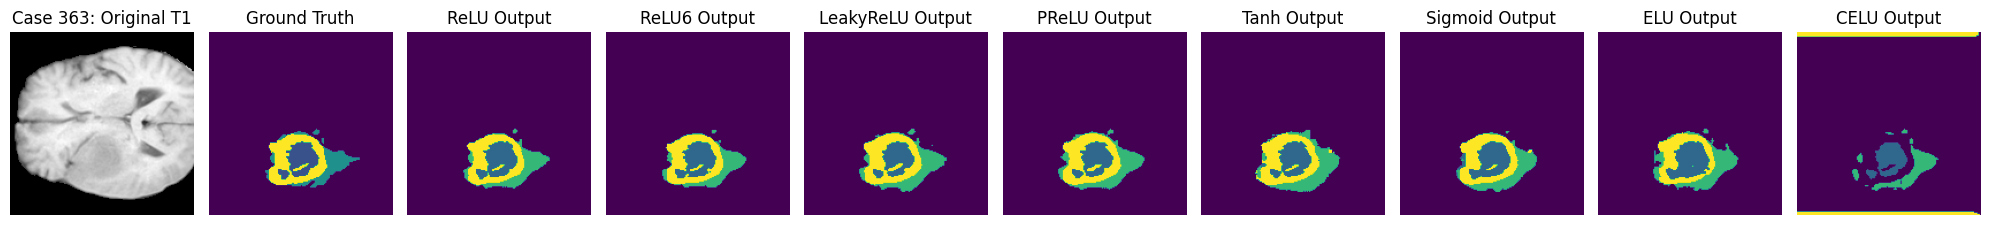

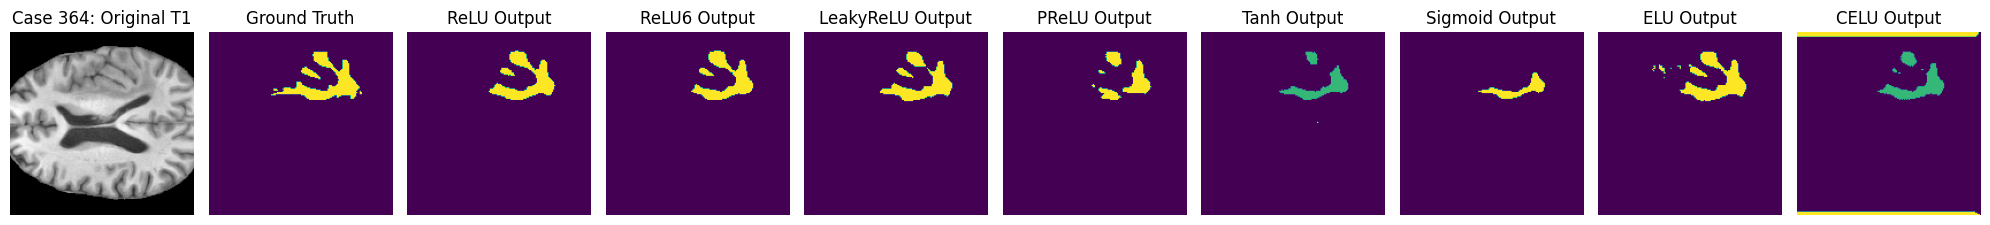

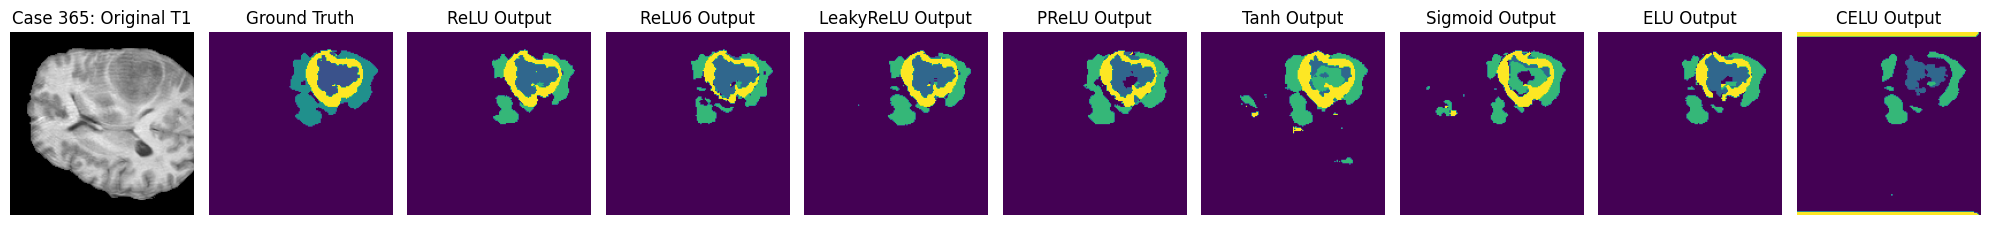

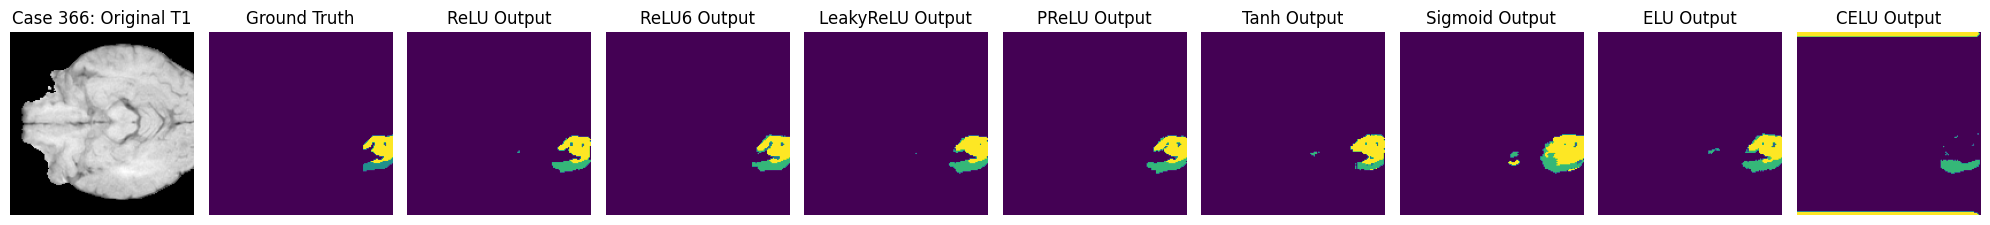

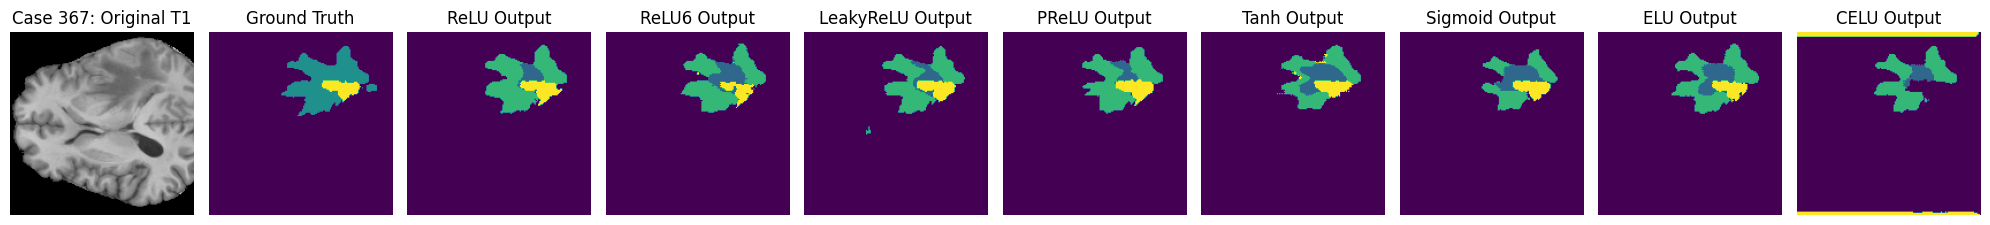

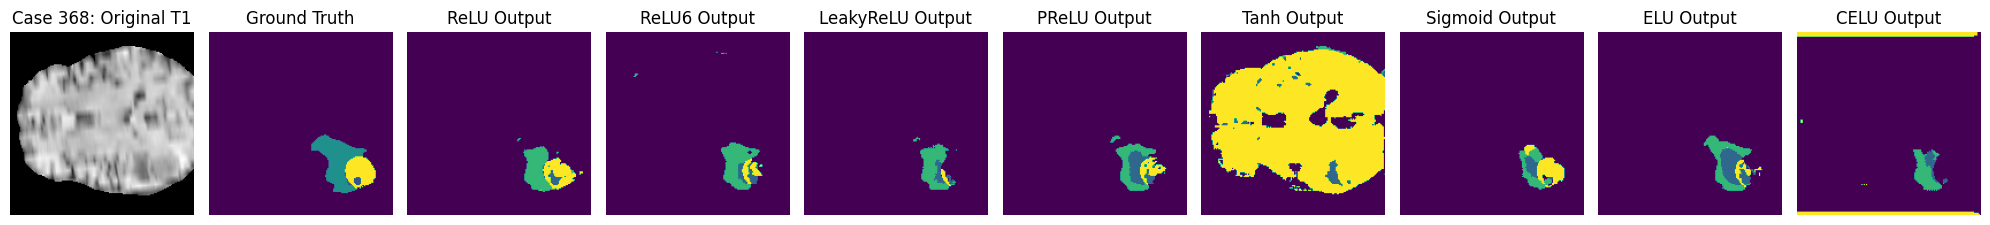

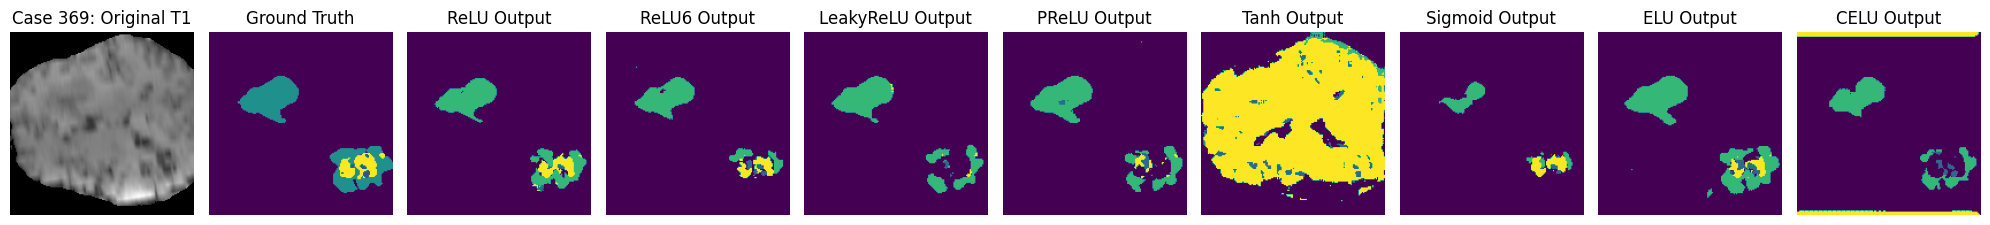

In [54]:
import torch
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImaged, EnsureTyped, CenterSpatialCropd
from monai.utils import ensure_tuple_rep

# Custom AddChannelD transform
class AddChannelD:
    def __init__(self, keys):
        self.keys = keys
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = d[key][None, ...]  # Add channel axis at the start
        return d

# Define paths
activations = ["ReLU", "ReLU6", "LeakyReLU", "PReLU", "Tanh", "Sigmoid", "ELU", "CELU"]
model_dir = "D:/thesis/Final/batchDemo models/"


# Define transforms
keys = ["t1", "t2", "t1ce", "flair", "seg"]
test_transforms = Compose([
    LoadImaged(keys=keys),
    AddChannelD(keys=keys),  # Add channel dimension manually
    CenterSpatialCropd(keys=keys, roi_size=(160, 160, 80)),  # Crop to required size
    EnsureTyped(keys=keys),
])

# Initialize storage for results
results = {activation: [] for activation in activations}

# Iterate over all cases in val_files
for case_idx, case in enumerate(val_files):
    # print(f"Processing case {case_idx + 1}: {case['filename']}")

    # Apply transforms
    transformed_sample = test_transforms(case)

    # Prepare input tensor
    inputs = torch.cat([
        transformed_sample["t1"],
        transformed_sample["t2"],
        transformed_sample["t1ce"],
        transformed_sample["flair"]
    ], dim=0).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    # Ground truth
    ground_truth = transformed_sample["seg"][0]

    # Process each activation function
    for activation in activations:
        # print(f"    Running model with activation: {activation}")
        model_path = f"{model_dir}/{activation}/model_{activation}_epoch_50.pth"

        # Define and load the model
        model = UNet(
            spatial_dims=3,
            in_channels=4,
            out_channels=4,
            channels=(16, 32, 64, 128),
            strides=(1, 2, 2, 2),
            kernel_size=3,
            act=activation,
        )
        model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()

        # Perform inference
        with torch.no_grad():
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax
            predicted_segmentation = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()  # Get predicted labels

        # Store the results
        results[activation].append((case_idx, predicted_segmentation))

    # Visualization
    slice_index = ground_truth.shape[-1] // 2  # Use middle slice for visualization

    plt.figure(figsize=(20, 10))
    cols = len(activations) + 2

    # Display original T1 image
    plt.subplot(2, cols, 1)
    plt.imshow(transformed_sample["t1"][0, :, :, slice_index], cmap="gray")
    plt.title(f"Case {case_idx + 1 +309}: Original T1")
    plt.axis("off")

    # Display ground truth
    plt.subplot(2, cols, 2)
    plt.imshow(ground_truth[:, :, slice_index], cmap="viridis")
    plt.title("Ground Truth")
    plt.axis("off")

    # Display predicted segmentations
    for i, activation in enumerate(activations):
        case_pred = next((pred for idx, pred in results[activation] if idx == case_idx), None)
        plt.subplot(2, cols, i + 3)
        plt.imshow(case_pred[:, :, slice_index], cmap="viridis")
        plt.title(f"{activation} Output")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [59]:
import os
import torch
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImaged, EnsureTyped, CenterSpatialCropd
from monai.utils import ensure_tuple_rep

# Custom AddChannelD transform
class AddChannelD:
    def __init__(self, keys):
        self.keys = keys
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = d[key][None, ...]  # Add channel axis at the start
        return d

# Define paths
activations = ["ReLU", "ReLU6", "LeakyReLU", "PReLU", "Tanh", "Sigmoid", "ELU", "CELU"]
model_dir = "D:/thesis/Final/batchDemo models/"
output_folder = "output_plots"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define transforms
keys = ["t1", "t2", "t1ce", "flair", "seg"]
test_transforms = Compose([
    LoadImaged(keys=keys),
    AddChannelD(keys=keys),  # Add channel dimension manually
    CenterSpatialCropd(keys=keys, roi_size=(160, 160, 80)),  # Crop to required size
    EnsureTyped(keys=keys),
])

# Initialize storage for results
results = {activation: [] for activation in activations}

# Iterate over all cases in val_files
for case_idx, case in enumerate(val_files):
    # Apply transforms
    transformed_sample = test_transforms(case)

    # Prepare input tensor
    inputs = torch.cat([
        transformed_sample["t1"],
        transformed_sample["t2"],
        transformed_sample["t1ce"],
        transformed_sample["flair"]
    ], dim=0).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    # Ground truth
    ground_truth = transformed_sample["seg"][0]

    # Process each activation function
    for activation in activations:
        model_path = f"{model_dir}/{activation}/model_{activation}_epoch_50.pth"

        # Define and load the model
        model = UNet(
            spatial_dims=3,
            in_channels=4,
            out_channels=4,
            channels=(16, 32, 64, 128),
            strides=(1, 2, 2, 2),
            kernel_size=3,
            act=activation,
        )
        model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()

        # Perform inference
        with torch.no_grad():
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax
            predicted_segmentation = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()  # Get predicted labels

        # Store the results
        results[activation].append((case_idx, predicted_segmentation))

    # Visualization
    slice_index = ground_truth.shape[-1] // 2  # Use middle slice for visualization

    plt.figure(figsize=(20, 10))
    cols = len(activations) + 2

    # Display original T1 image
    plt.subplot(1, cols, 1)
    plt.imshow(transformed_sample["t1"][0, :, :, slice_index], cmap="gray")
    plt.title(f"Case {case_idx + 1 +309}: Original T1")
    plt.axis("off")

    # Display ground truth
    plt.subplot(1, cols, 2)
    plt.imshow(ground_truth[:, :, slice_index], cmap="viridis")
    plt.title("Ground Truth")
    plt.axis("off")

    # Display predicted segmentations
    for i, activation in enumerate(activations):
        case_pred = next((pred for idx, pred in results[activation] if idx == case_idx), None)
        plt.subplot(1, cols, i + 3)
        plt.imshow(case_pred[:, :, slice_index], cmap="viridis")
        plt.title(f"{activation} Output")
        plt.axis("off")

    plt.tight_layout()

    # Save the plot to the output folder
    plot_filename = os.path.join(output_folder, f"case_{case_idx + 1 +309}_activations.png")
    plt.savefig(plot_filename, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free up memory


In [44]:
val_files

[{'filename': 'BraTS20_Training_310',
  't1': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_310\\BraTS20_Training_310_t1.nii',
  't2': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_310\\BraTS20_Training_310_t2.nii',
  't1ce': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_310\\BraTS20_Training_310_t1ce.nii',
  'flair': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_310\\BraTS20_Training_310_flair.nii',
  'seg': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_310\\BraTS20_Training_310_seg.nii'},
 {'filename': 'BraTS20_Training_311',
  't1': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_311\\BraTS20_Training_311_t1.nii',
  't2': 'D:/thesis/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_311\\Bra